<img src='img/logo.png' width=200>
<center>
    <br/>
    Master (Završni) rad 
    <br/>
    Predviđanje prodaje multinacionalne maloprodajne korporacije korišćenjem algoritama mašinskog učenja
    <br/>
    Ivana Todorović 2020/3060
    <br/>
</center>


In [1]:
# Uvoz standardnih biblioteka potrebnih za ceo projekat

import numpy as np
import pandas as pd
import warnings
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from pandasql import sqldf
import plotly.express as px
from scipy.stats import zscore
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
warnings.filterwarnings("ignore")

In [2]:
# Instalacija paketa

!pip install missingno
!pip install pandasql
!pip install plotly
!pip install scikit-learn
!pip install xgboost

In [3]:
# Ucitavanje train data set-a

train_data = pd.read_csv('data/train.csv')

In [4]:
# Ucitavanje test data set-a

test_data = pd.read_csv('data/test.csv')

In [5]:
# Ucitavanje stores data set-a

stores_data = pd.read_csv('data/stores.csv')

In [6]:
# Ucitavanje features data set-a

features_data = pd.read_csv('data/features.csv')

## 1. Opis podataka

In [7]:
'''
Prikaz train data set-a
Skup podataka za ucenje modela koji ce biti podeljen na train i test, nakon spajanja sa drugim podacima
'''

train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


- Store	= Broj prodavnice. Ukupno ih ima 45
- Dept	= Broj odeljenja
- Date	= Datum koji predstavlja nedelju
- Weekly_Sales	= Izlazna promenljiva koja oznacava ostvarenu nedeljnu prodaju za odredjeno odeljenje u odredjenoj prodavnici
- IsHoliday = Podatak koji pokazuje da li je data nedelja praznik

In [8]:
'''
Prikaz test data set-a
Test skup podataka za kreiranje konacnih predikcija
Isti skup podataka kao i prethodni, ali bez atributa koji se predvidja to jest Weekly_Sales
'''

test_data.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [9]:
# Prikaz stores data set-a. Prikaz podataka o 45 prodavnica

stores_data.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


- Store = Broj prodavnice. Ukupno ih ima 45
- Type  = Tip prodavnice (A, B, C)
- Size	= Velicina prodavnice

In [10]:
'''
Prikaz features data set-a
Ovaj data set sadrzi dodatne informacije o prodavnici, odeljenju, regionu.
'''

features_data.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


- Store	= Broj prodavnice. Ukupno ih ima 45
- Date	= Datum koji predstavlja nedelju
- Temperature = Prosecna temperatura u regionu
- Fuel_Price  = Troskovi goriva u regionu
- MarkDown1-5 = Anonimni podaci koji se ticu promotivnih snizenja koje je kompanija Walmart organizovala. Ovi podaci su dostupni od meseca novembra 2011. godine i nisu dostupni za svaku prodavnicu stalno. Prisutne su nedostajuce vrednosti koje su oznacene sa NA
- CPI	= Indeks potrosackih cena
- Unemployment	= Stopa nezaposlenosti
- IsHoliday	= Binarna promenljiva koja ima vrednosti True u slucaju da je nedelja praznik i False u slucaju da nedelja nije praznik. Podaci o datumima praznika dati su u opisu takmicenja


## 2. Tumacenje podataka

In [11]:
'''
Spajanje train, features i stores skupova u podataka u jedan zajednicki koji ce biti koriscen za kreiranje modela
Bice kreiran poseban data set za potrebe vizualizacija
'''

data_vis = pd.merge(train_data, features_data, on=['Store','Date','IsHoliday'], how='inner')

data_v = pd.merge(data_vis, stores_data, on=['Store'], how='inner')

In [633]:
'''
Vizualizacije
Bice kreirane razlicite vizualizacije koriscenjem razlicitih paketa i biblioteka 
'''

def graph_weekly_sale(col_relation, df, x='Week', palette=None):
    
    df.Date = pd.to_datetime(df.Date)
    df['Week'] = df.Date.dt.week
    df['Month'] = df.Date.dt.month
    df['Year'] = df.Date.dt.year
    
    cmap = sns.diverging_palette(240, 20, as_cmap=True)

    sns.relplot(
        x=x,
        y='Weekly_Sales',
        hue=col_relation,
        data=df,
        kind='line',
        height=5,
        aspect=2,
        palette=palette
    )
    plt.show()

### Prikaz kretanja prodaje Weekly_Sales kroz vreme Date. Uvidjamo pikove u prodaji krajem godina kada su praznici Bozic i Dan zahvalnosti.

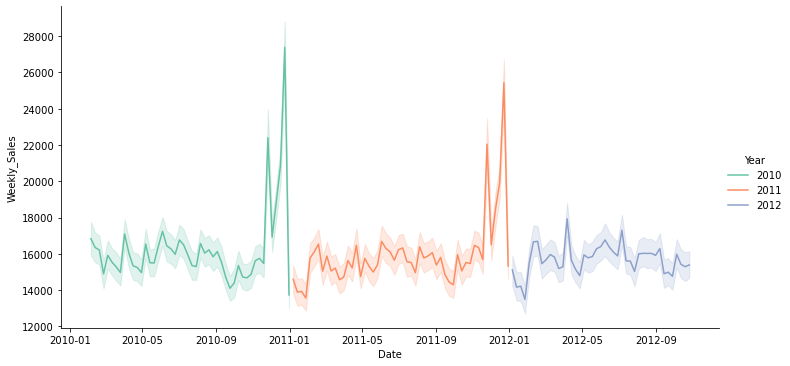

In [634]:
graph_weekly_sale('Year', data_v, x='Date', palette='Set2')

### Prikaz kretanja prodaje po godinama. Uvidjamo da se prodaja smanjuje, ali je potrebno pazljivo donositi zakljucake buduci da ne postoje podaci za praznike Bozic i Dan zahvalnosti u 2012. godini.

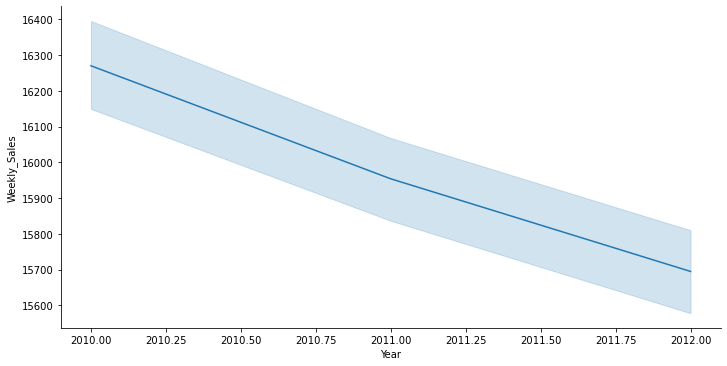

In [635]:
graph_weekly_sale(None, data_v, x='Year')

### Prikaz kretanja prodaje po mesecima. Ovaj grafik nam daje bolji prikaz kretanja prodaje po mesecima. Opet uvidjamo da prodaja raste pri kraju godine to jest u poslednjim mesecima.

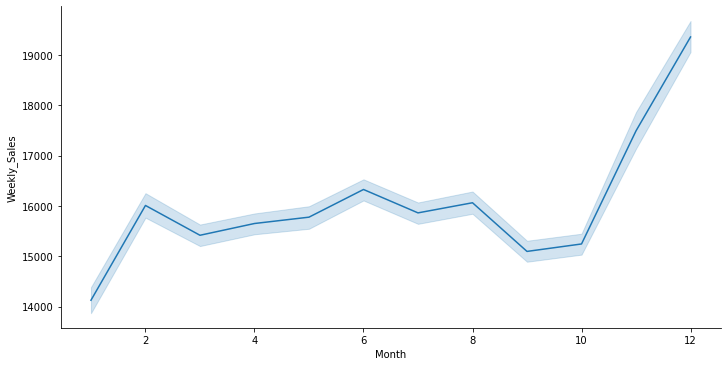

In [636]:
graph_weekly_sale(None, data_v, x='Month')

### Prikaz kretanja prodaje po nedeljama. Ponovo su poslednje nedelje kljucne u povecanju prodaje

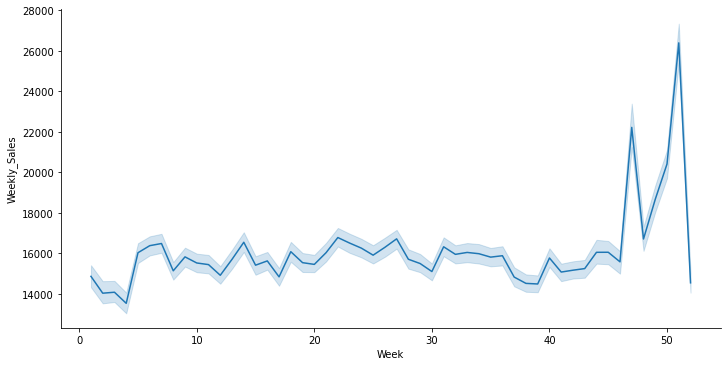

In [637]:
graph_weekly_sale(None, data_v, x='Week')

### Broj prodavnica Store po tipovima Type = A, B, C. Dakle, tip A je najvise zastupljen, zatim B i na kraju tip C (uvidjamo relaciju A>B>C).

<AxesSubplot:xlabel='Type', ylabel='count'>

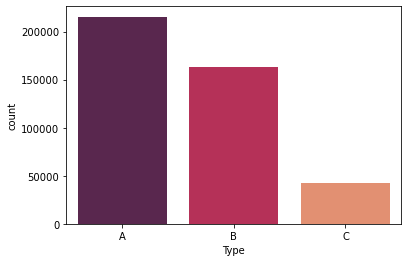

In [638]:
sns.countplot(x="Type", data=data_v, palette="rocket")

### Precizniji prikaz broja prodavnica po tipovima. Novi tip vizualizacija u vidu interaktivne mape.

In [639]:
typecounts = data_v.Type.value_counts().to_dict()
df = pd.DataFrame(list(typecounts.items()), columns=['Tip prodavnice', 'Ukupno'])

fig = px.pie(df, values='Ukupno', names='Tip prodavnice',
             title='Zastupljenost tipova prodavnice',labels='Tip prodavnice')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Prosecna prodaja po svakom tipu prodavnice. Kao i kod zastupljenosti tipova prodavnice, isti je slucaj i sa prodajom. Tip prodavnice A ostvaruje najvecu prodaju, zatim slede tipovi B i C.

In [640]:
avgweeklysales = data_v.groupby('Type')['Weekly_Sales'].mean().to_dict()
df = pd.DataFrame(list(avgweeklysales.items()), columns=['Type', 'Avg_Weekly_Sales'])

fig = px.bar(df, 
             x="Type", 
             y="Avg_Weekly_Sales",  
             title="Prosecna prodaja po tipu prodavnice",
             color_discrete_sequence=["#167378"])
fig.show()

### Velicina prodavnice Size oznacava broj dostupnih artikala i u rasponu je od 34 875 do 219 622.

In [641]:
print('Minimalna vrednost atributa Size: ', data_v['Size'].min())
print('Maksimalna vrednost atributa Size: ', data_v['Size'].max())

Minimalna vrednost atributa Size:  34875
Maksimalna vrednost atributa Size:  219622


### Prikaz prodaje Weekly_Sales u zavisnosti od tipa prodavnice Type = A, B, C i velicine Size. Prodavnice tipa C ostvaruju najmanju prodaju, tip B srednju, tip A najvecu. Moze se uvideti da prodaja varira zbog velicine tipova prodavnica.

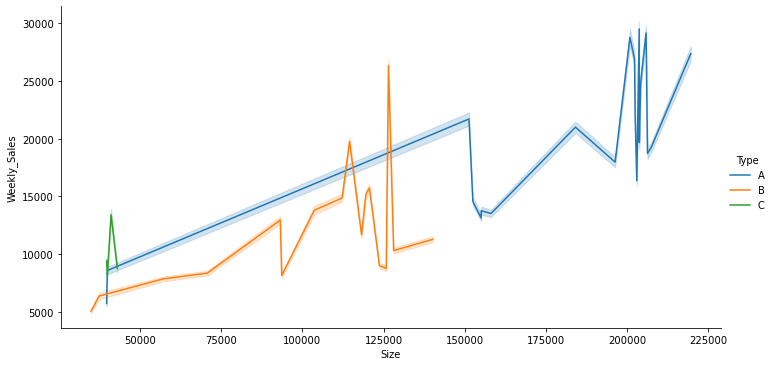

In [642]:
graph_weekly_sale('Type', data_v, 'Size')

### Prikaz ostvarene prodaje po tipu prodavnice kroz vreme to jest nedelje. Malo jasnije uvidjamo relaciju A>B>C i opet su prisutni veliki pikovi u prodaji na kraju godine, tj. u poslednjim nedeljama. Mada postoji blagi rast prodaje od 11. do 12. nedelje sto treba naknadno ispitati da li postoji jos neki bitan praznik kada se prodaja u Walmart prodavnicama povecava, a koji nije dat u opisu takmicenja.

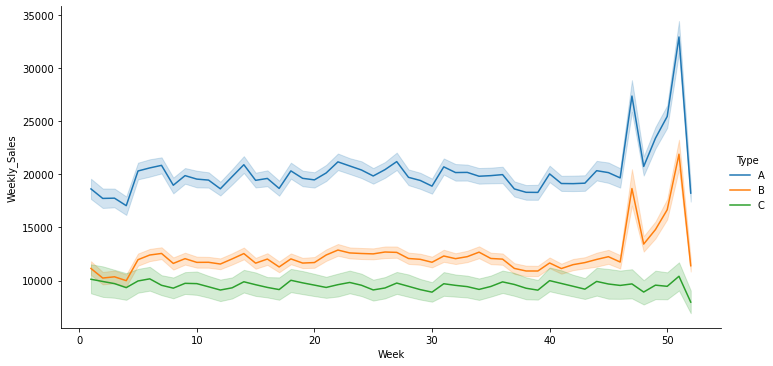

In [643]:
graph_weekly_sale('Type', data_v)

In [644]:
def plot_groupped_graph(col1, col2, df):

    if col2:
        df = (
            df[[col1, col2, 'Weekly_Sales']]
            .groupby([col1, col2])
            .mean()
            .sort_values('Weekly_Sales', ascending=False)
        )
    else:
        df = (
            df[[col1, 'Weekly_Sales']]
            .groupby([col1])
            .mean()
            .sort_values('Weekly_Sales', ascending=False)
        )

    df.reset_index(inplace=True)
    sns.relplot(
        x=col1,
        y='Weekly_Sales',
        hue=col2,
        data=df.sort_values(col1),
        height=5,
        aspect=2
    )

### Prikaz zavisnosti ostvarene prodaje, tipa prodavnice i da li je bilo praznika. Za tip prodavnice A uvidjamo da je veca prodaja dostignuta za vreme praznika sto je slucaj i sa tipom prodavnica B.

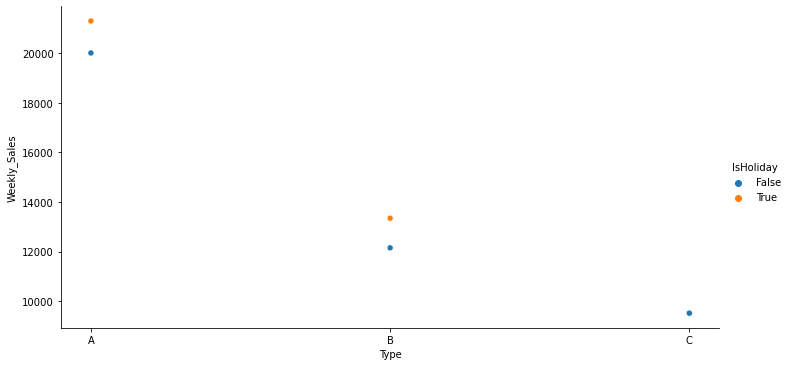

In [645]:
plot_groupped_graph('Type', 'IsHoliday', data_v)

### Prikaz ostvarene prodaje po odeljenjima Dept.

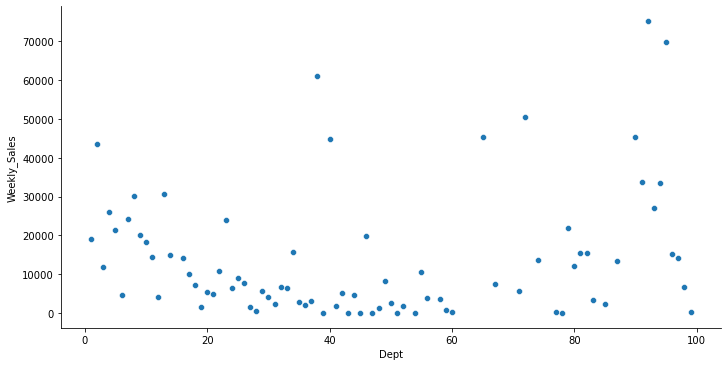

In [646]:
plot_groupped_graph('Dept', None, data_v)

### Prikaz ostvarene prodaje po odeljenjima ali sa aspekta da li je bio praznik ili ne.

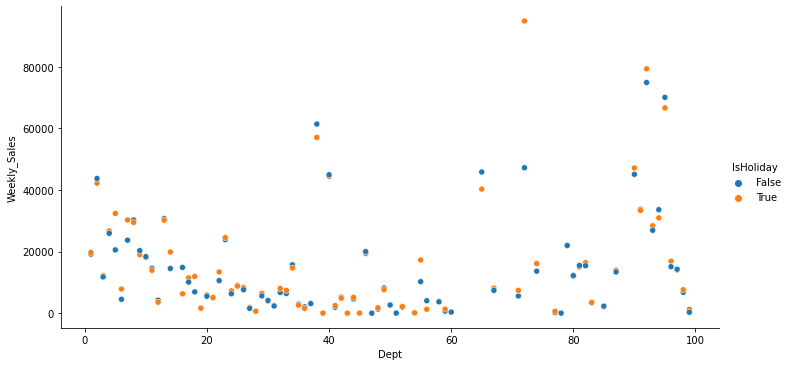

In [647]:
plot_groupped_graph('Dept', 'IsHoliday', data_v)

### Raspodela izlazne promenljive. Raspodela pomerena u levo, dakle bice potrebno logaritmovati ovu promenljivu.

<AxesSubplot:ylabel='Frequency'>

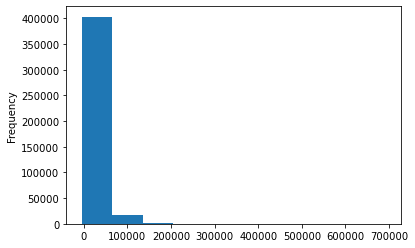

In [648]:
data_vis["Weekly_Sales"].plot.hist()

### Broj opservacija u zavisnosti od toga da li je bio praznik ili ne.

<AxesSubplot:xlabel='IsHoliday', ylabel='count'>

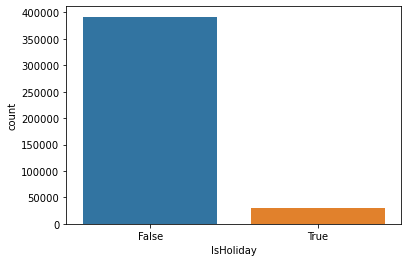

In [649]:
sns.countplot(x ="IsHoliday", data =data_v)

### Precizniji pregled broja opservacija u zavisnosti od toga da li je bio praznik ili ne.

In [650]:
print('Broj opservacija - nije praznik: ',data_v[data_v['IsHoliday']==False]['Weekly_Sales'].count().round(1))
print('Broj opservacija - praznik : ',data_v[data_v['IsHoliday']==True]['Weekly_Sales'].count().round(1))

Broj opservacija - nije praznik:  391909
Broj opservacija - praznik :  29661


### Uporedni prikaz broja opservacija i prosecne ostvarene prodaje sa aspekta da je bio praznik ili ne.

In [651]:
holiday_sales = data_v.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_counts = data_v.IsHoliday.value_counts()

fig = make_subplots(rows=1, cols=2, subplot_titles=("Praznik/Nije praznik - Ostvarena prodaja", "Praznik/Nije praznik - Broj opservacija"))

fig.add_trace(go.Bar(x=holiday_sales.values, y=holiday_sales.index, orientation='h',),1, 1)

fig.add_trace(go.Bar(x=holiday_counts.values, y=holiday_counts.index, orientation='h',),1, 2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), template='plotly_white', showlegend=False)
fig.show()

### Precizniji pregled ostvarene prodaje u zavisnosti od toga da li je bio praznik ili ne.

In [652]:
print('PROSECNA PRODAJA\n')
print('Ostvarena prodaja - praznik : ',data_v[data_v['IsHoliday']==True]['Weekly_Sales'].mean())
print('Ostvarena prodaja - nije praznik: ',data_v[data_v['IsHoliday']==False]['Weekly_Sales'].mean())
print('\nUKUPNA PRODAJA\n')
print('Ostvarena prodaja - praznik : ',data_v[data_v['IsHoliday']==True]['Weekly_Sales'].sum())
print('Ostvarena prodaja - nije praznik: ',data_v[data_v['IsHoliday']==False]['Weekly_Sales'].sum())

PROSECNA PRODAJA

Ostvarena prodaja - praznik :  17035.823187350474
Ostvarena prodaja - nije praznik:  15901.445069008503

UKUPNA PRODAJA

Ostvarena prodaja - praznik :  505299551.56000006
Ostvarena prodaja - nije praznik:  6231919435.55


### Prikaz nedostajucih vrednosti. Izsrafirane povrsine ukazuju da ti atributi sadrze opservacije koje imaju NA vrednosti.

<AxesSubplot:>

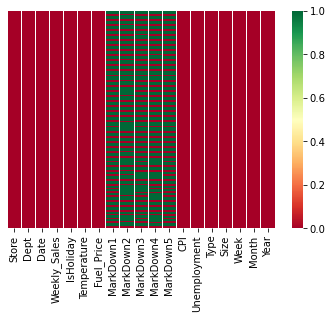

In [653]:
sns.heatmap(data_v.isnull(),yticklabels=False, cmap="RdYlGn")

### Prosecna prodaja po svakoj prodavnici. 

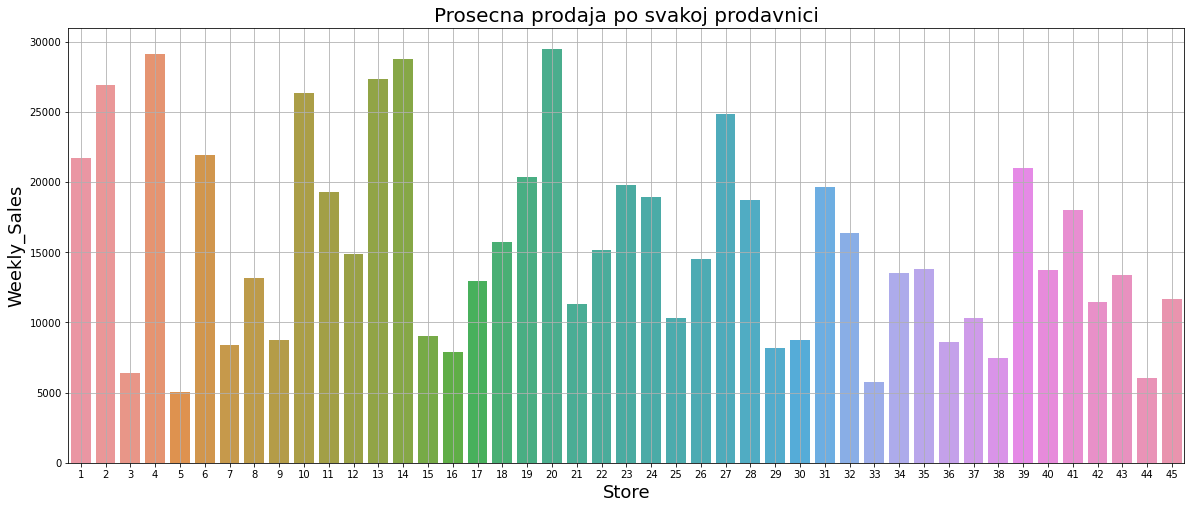

In [654]:
avg_weekly_sales = data_v['Weekly_Sales'].groupby(data_v['Store']).mean()

plt.figure(figsize=(20,8))
sns.barplot(avg_weekly_sales.index, avg_weekly_sales.values)

plt.grid()
plt.title("Prosecna prodaja po svakoj prodavnici", fontsize = 20)
plt.ylabel('Weekly_Sales', fontsize=18)
plt.xlabel("Store", fontsize=18)
plt.show()

### Prosecna prodaja po svakom odeljenju. Uvidjamo da odeljenje 15 nije na listi.

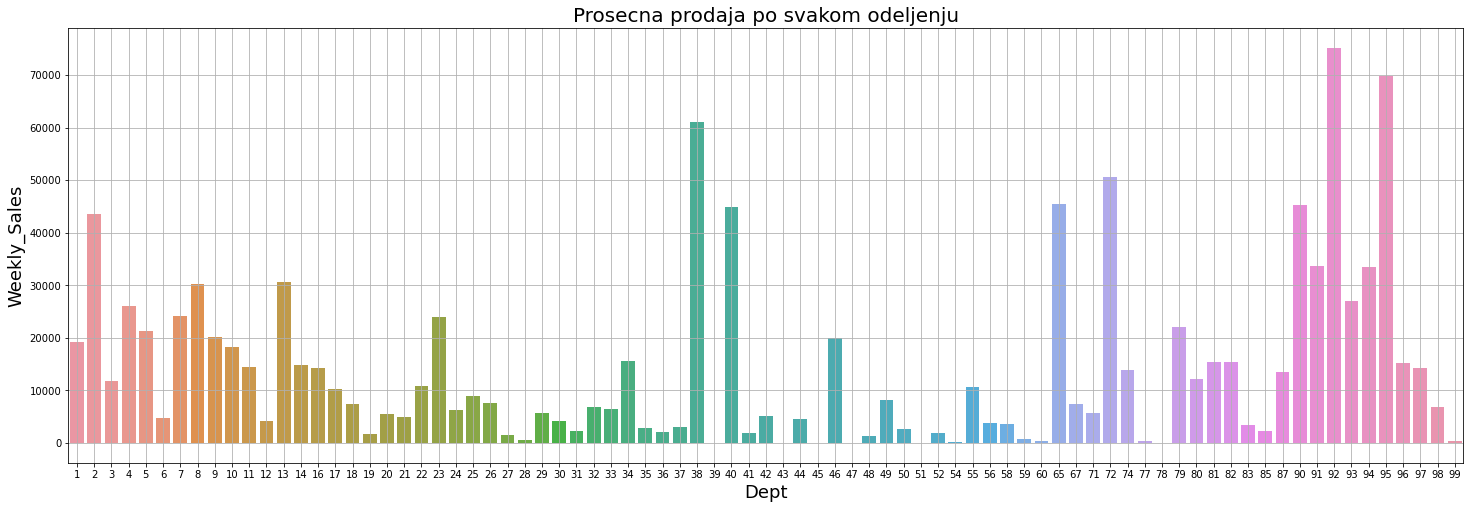

In [655]:
avg_weekly_sales = data_v['Weekly_Sales'].groupby(data_v['Dept']).mean()

plt.figure(figsize=(25,8))
sns.barplot(avg_weekly_sales.index, avg_weekly_sales.values)
plt.grid()
plt.title("Prosecna prodaja po svakom odeljenju",fontsize=20)
plt.ylabel("Weekly_Sales", fontsize=18)
plt.xlabel("Dept", fontsize=18)
plt.show()

### Za odeljenje 15 nemamo podatke.

In [656]:
data_v[data_v['Dept'] == 15].Weekly_Sales

Series([], Name: Weekly_Sales, dtype: float64)

In [657]:
data_v[data_v['Dept'] == 15]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Month,Year


## 3. Priprema podataka

In [1022]:
train_features_data = pd.merge(train_data, features_data, on = ['Store','Date','IsHoliday'], how = 'inner')

final_data = pd.merge(train_features_data, stores_data, on = ['Store'], how = 'inner')

In [1023]:
# Prikaz podataka

final_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [1024]:
'''
Informacije o podacima
Uvidjamo da postoje neke nedostajuce vrednosti i tipovi atributa kao sto je object ili bool
Potrebno je resiti ove probleme
'''

final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [1025]:
'''
Osnovni parametri deskriptivne statistike mogu se videti uz pomoc funkcije describe(). 
Osnovni statistički parametri deskriptivne statistike su:
 - Broj podataka u svakoj koloni (count)
 - Aritmeticka sredina (mean)
 - Standardna devijacija (std)
 - Minimalna vrednost u koloni (min)
 - 25% skupa
 - 50% skupa
 - 75% skupa
 - Maksimalna vrednost u koloni (max)
 
Ukoliko se uoci da neka varijabla ima standardnu devijaciju to jest varijansu (var) 0.0 moze se ukloniti iz dalje analize.
Takodje, vidimo da postoje negativne vrednosti izlaznog atributa Weekly_Sales pa je neophodno utvrditi da li su takve 
opservacije znacajne za ovo istrazivanje ili ih ipak treba izbaciti.

'''

final_data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [1026]:
print(final_data.Fuel_Price.var())

0.21023558075746615


In [1027]:
# Provera da li postoje nedostajuce vrednosti

final_data.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [1028]:
# Detaljniji prikaz NA vrednosti

null_columns = (final_data.isnull().sum(axis = 0)/len(final_data)).sort_values(ascending=False).index
null_data = pd.concat([
    final_data.isnull().sum(axis = 0),
    (final_data.isnull().sum(axis = 0)/len(final_data)).sort_values(ascending=False),
    final_data.loc[:, final_data.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: 'Ukupno NA vrednosti', 
                                      1: 'Procenat NA vrednosti', 
                                      2: 'Tip NA vrednosti'}).sort_values(ascending=False, by = 'Procenat NA vrednosti')
null_data = null_data[null_data["Ukupno NA vrednosti"]!=0]
null_data

,Ukupno NA vrednosti,Procenat NA vrednosti,Tip NA vrednosti
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


<AxesSubplot:>

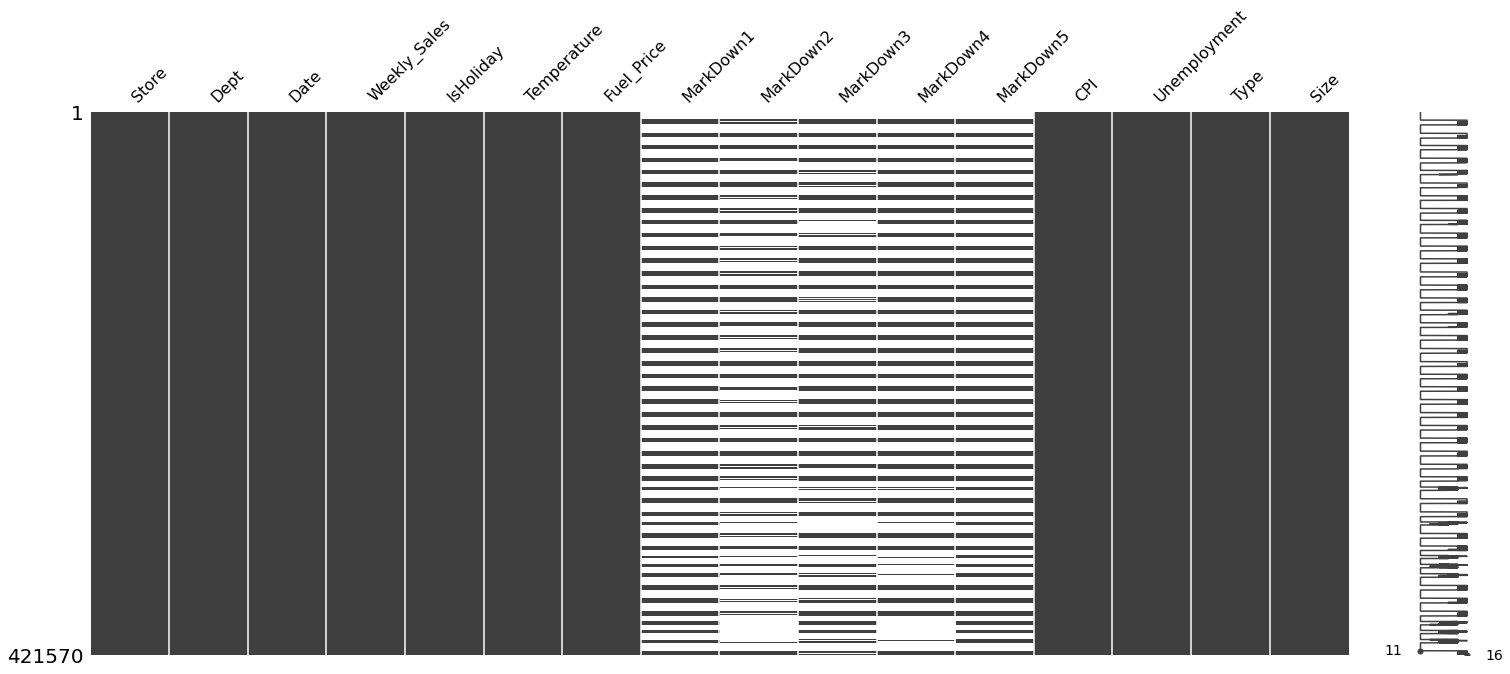

In [1029]:
'''
Vizualizacija nedostajucih vrednosti
Kolone koje imaju nedostajuce vrednosti iscrtane su linijama. Sto vise crtica ima to ukazuje da dati atribut ima 
vise NA vrednosti.
'''

msno.matrix(final_data)

<AxesSubplot:>

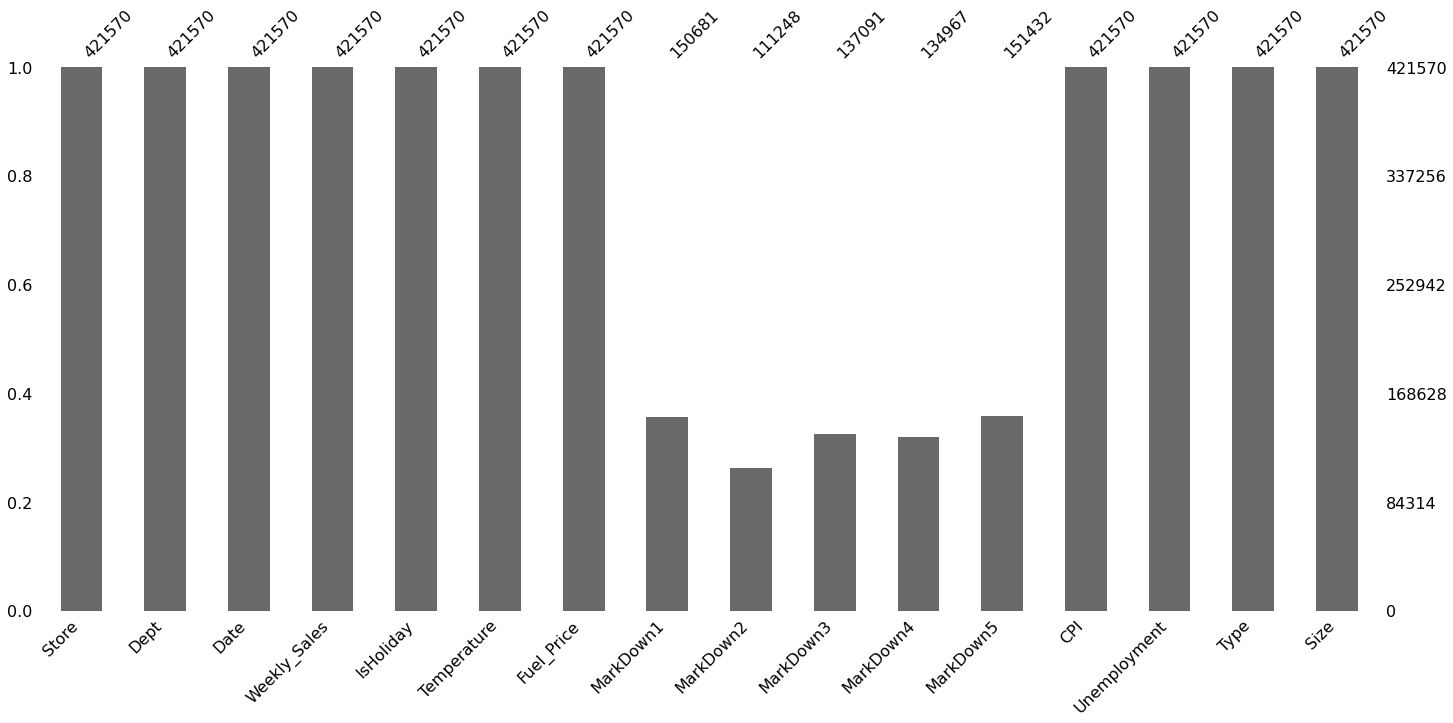

In [1030]:
'''
Vizualizacija broja opservacija po atributima
Iznos jednog "stubica" govori o broju opservacija za taj atribut, kao i ranije uvidjamo da atributi
MarkDown1-5 imaju manji broj opservacija od ostalih sto ukazuje na problem postojanja NA vrednosti.
'''

msno.bar(final_data)

### Vizualizacija nedostajucih vrednosti = Vizualizacija nedostajucih vrednosti preko heat mape gde je prikazana korelacija pojavljivanja nedostajucih vrednosti
### Ukoliko je vrednost blizu -1 to znaci da ako se pojavi jedna promenljiva, velika je verovatnoca da ce druga promenljiva nedostajati.
### Ukoliko je vrednost blizu 0 nema zavisnosti izmedju pojavljivanja nedostajucih vrednosti dve promenljive.
### Ukoliko je vrednost blizu 1 znaci ako se pojavi jedna promenljiva, velika je verovatnoca da ce biti prisutna i druga promenljiva.

<AxesSubplot:>

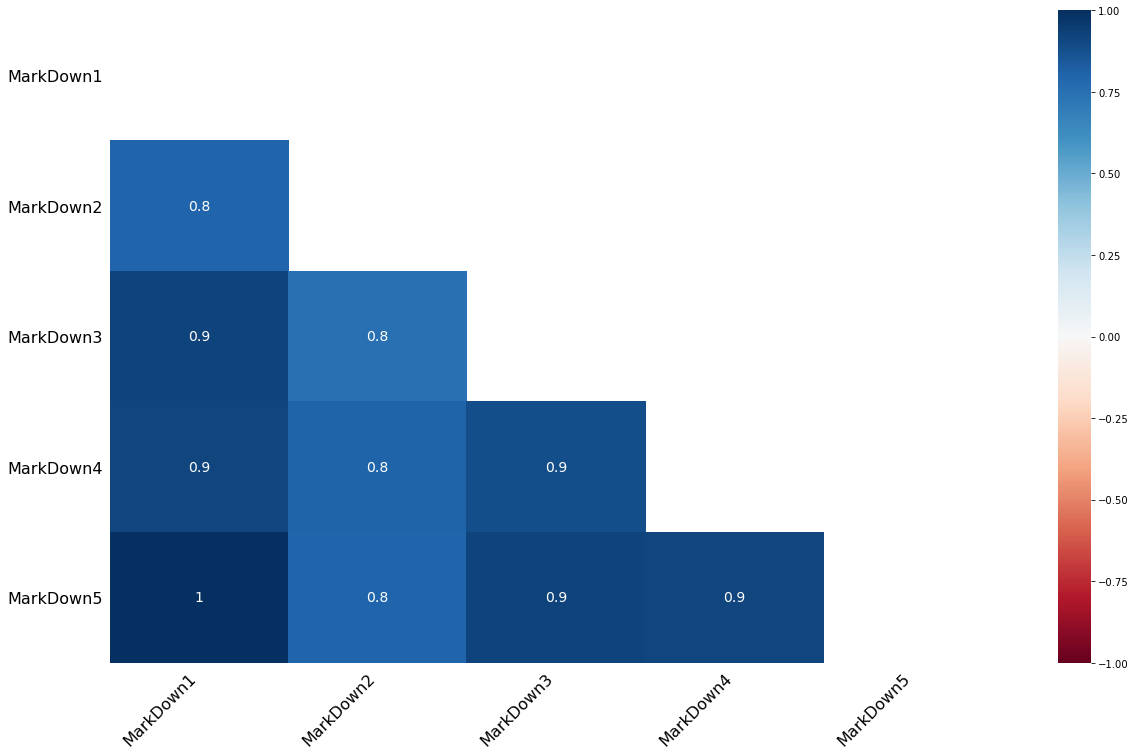

In [1031]:
msno.heatmap(final_data)

In [1032]:
# Popunjavanje nedostajucih vrednosti nulom za kolone MarkDown1-5

final_data['MarkDown1'] = final_data['MarkDown1'].fillna(0)
final_data['MarkDown2'] = final_data['MarkDown2'].fillna(0)
final_data['MarkDown3'] = final_data['MarkDown3'].fillna(0)
final_data['MarkDown4'] = final_data['MarkDown4'].fillna(0)
final_data['MarkDown5'] = final_data['MarkDown5'].fillna(0)

In [1033]:
final_data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [1034]:
# II nacin za popunjavanje nedostajucih vrednosti 

In [1035]:
'''
Popunjavanje nedostajucih vrednosti na osnovu KNN principa
Prvo se pronalazi zadati broj "suseda" to jest uzoraka koji su slicni po svim atributima sa onim uzorkom
gde postoji nedostajuca vrednost. Zatim se racuna prosecna vrednost susednih uzoraka i ona se upisuje 
u trenutnu nedostajucu vrednost. Proces se ponavlja dok se sve nedostajuce vrednosti ne popune.
'''

imputer = KNNImputer(n_neighbors = 3, weights = 'uniform')
final_data_num = final_data[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]

In [1036]:
'''
Sa metodom fit se uci model, ali se metodom transform podaci transofrmisu. 
Kada se zeli primeniti istovremeno i ucenje i primena postoji funkcija fit_transform.
'''

final_data_num_t = imputer.fit_transform(final_data_num)

In [1037]:
final_data_num_t = pd.DataFrame(final_data_num_t, index = final_data_num.index , columns = final_data_num.columns)

In [1038]:
final_data_num_t.isna().sum()

MarkDown1    0
MarkDown2    0
MarkDown3    0
MarkDown4    0
MarkDown5    0
dtype: int64

In [1039]:
final_data['MarkDown1'] = final_data_num_t['MarkDown1']
final_data['MarkDown2'] = final_data_num_t['MarkDown2']
final_data['MarkDown3'] = final_data_num_t['MarkDown3']
final_data['MarkDown4'] = final_data_num_t['MarkDown4']
final_data['MarkDown5'] = final_data_num_t['MarkDown5']

In [1040]:
final_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


### I matrica korelacije = Prikaz zavisnosti atributa
### Sto je korelacija jaca izmedju atributa to je boja na slici jaca. Zavisnost izmedju atributa znaci da ako se jedna promenljiva poveca i druga ce se povecati, ukoliko se jedna smanji i druga ce se smanjiti. 
### Sledeci Pirsonov koeficijent korelacije znamo sledece
### 0 = ne postoji zavisnost izmedju atributa
### 0 - 0.3 = slaba zavisnost
### 0.3 - 0.7 = umerena zavisnost
### 0.7 - 1 = jaka zavisnost

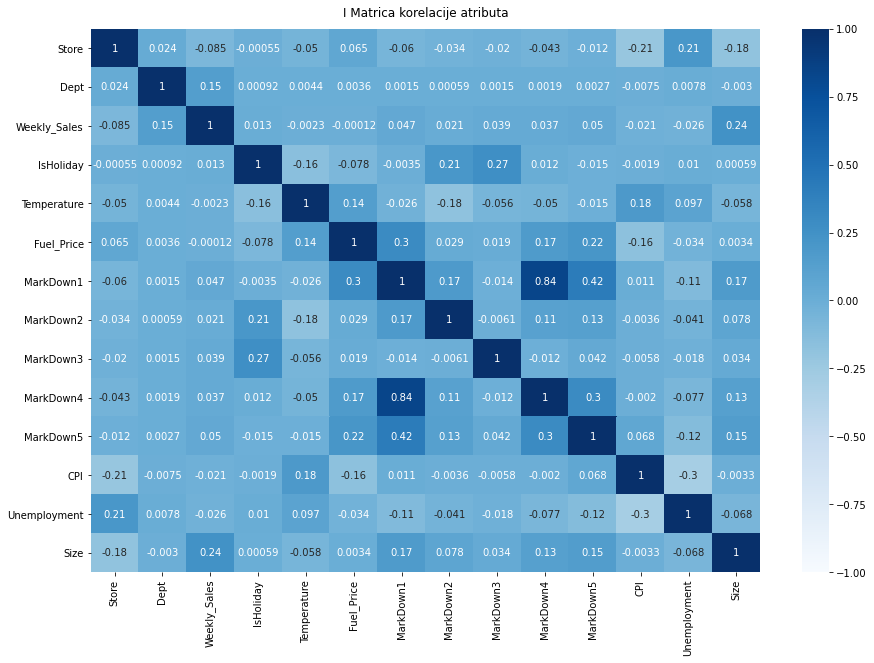

In [1041]:
plt.figure(figsize=(15, 10))

heatmap = sns.heatmap(final_data.corr(), vmin=-1, vmax=1, annot=True,cmap="Blues", annot_kws={"fontsize":10})
heatmap.set_title('I Matrica korelacije atributa', fontdict={'fontsize':12}, pad=12);

### Po dijagonali su ocekivano jedinice buduci da je tu atribut povezan sam sa sobom. Visoku korelaciju vidimo izmedju atributa Markdown1 i Markdown4 koji ce biti uklonjeni da ne bi doveli do pojave suma u podacima. Dodatan motiv za uklanjanje ovih atributa je i cinjenica da postoji veliki broj NA vrednosti, a kako su atributi visoko korelisani pogresne vrednosti bi mogle da dovedu do pogresnih zakljucaka. Generalno gledano buduci da postoji veliki broj inicijalno nedostajucih vrednosti za kolone MarkDown1-5 i pomenuti atributi nemaju znacajnu korelaciju sa izlaznom varijablom Weekly_Sales (takodje ovo su podaci cije tacno i precizno znacenje ne znamo) ove atribute mozemo ukloniti.

Text(0, 0.5, 'MarkDown4')

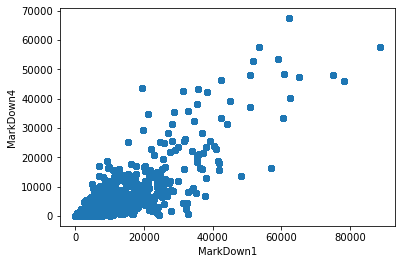

In [1042]:
'''
Prikaz zavisnosti atributa MarkDown1 i MarkDown4 koriscenjem scatter plot-a
Tackice na grafiku, u slucaju prave linearne zavisnosti, kreiraju nagnutu (pod uglom od 45 stepeni), pravu liniju 
U ovom slucaju tackice kreiraju umerenu liniju koja ukazuje da ipak postoji zavisnost izmedju ova dva atributa
'''


plt.scatter(final_data['MarkDown1'], final_data['MarkDown4'])

plt.xlabel('MarkDown1')
plt.ylabel('MarkDown4')

In [1043]:
# Uklanjanje visoko korelisanih varijabli MarkDown1 i MarkDown4

final_data = final_data.drop(["MarkDown1", "MarkDown4"], axis = 1)

In [1044]:
'''
Takodje, kao sto je receno, buduci da preostali atributi MarkDown2, MarkDown3, MarkDown5 imaju slabu korelaciju (oko 0) sa 
izlaznim atributom Weekly_Sales mozemo ih ukloniti
'''

final_data = final_data.drop(["MarkDown2", "MarkDown3", "MarkDown5"], axis = 1)

### Takodje mozemo videti da su atributi Temperatura, CPI i Unemployment slabo korelisani sa izlaznim atributom Weekly_Sales pa je potrebno izvrsiti analizu u cilju njihovog uklanjanja.

In [1045]:
data_vis = pd.merge(train_data, features_data, on=['Store','Date','IsHoliday'], how='inner')
data_vis_temp = pd.merge(data_vis, stores_data, on=['Store'], how='inner')

In [1046]:
# Buduci da je temperatura data u Farenhajtima, cisto za potrebe tumacenja i jasnoce pretvoricemo u stepene Celzijusove

data_vis_temp['Temperature'] = (data_vis['Temperature'] - 32) * 5/9

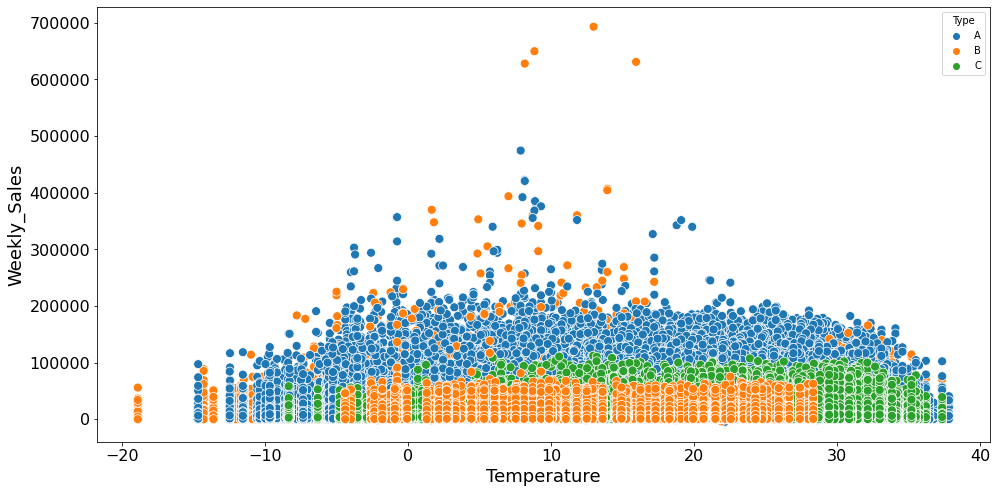

In [1047]:
'''
Temperatura regiona i ostvarena nedeljna prodaja u zavisnosti od tipa prodavnice.
Mozemo uociti da i nema neke zavisnosti izmedju temperature koja je u regionu i ostvarene nedeljne prodaje. 
Na niskim i visokim temperaturama prodaja malo opada, ali u ostalim slucajevima cini se da ne postoji jasna veza.
Zbog toga ovu varijablu mozemo ukloniti.
'''

plt.figure(figsize=(16,8))
sns.scatterplot(x=data_vis_temp.Temperature, y=data_vis_temp.Weekly_Sales, hue=data_vis_temp.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Weekly_Sales', fontsize=18);

In [1048]:
# Uklanjanje atributa Temperature

final_data = final_data.drop(["Temperature"], axis = 1)

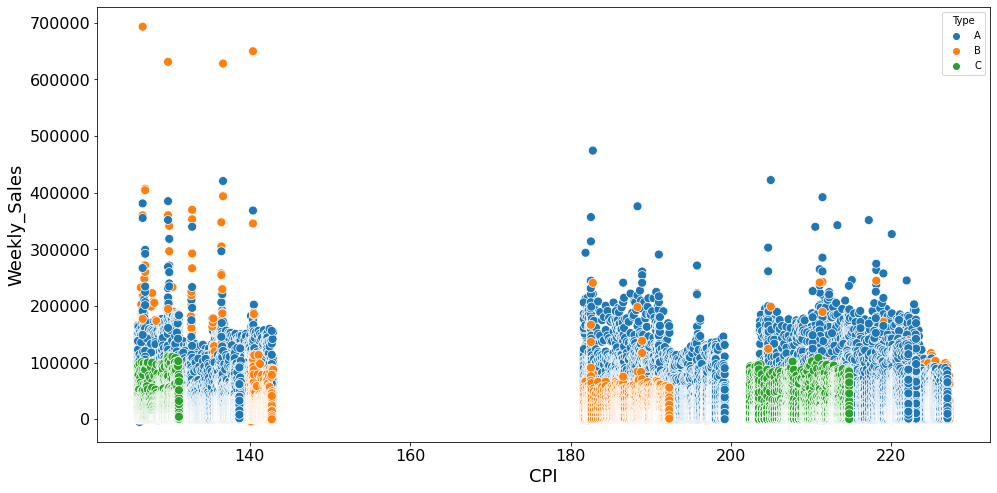

In [1049]:
'''
Isti postupak cemo primeniti i za prikaz odnosa izmedju atributa CPI i Weekly_Sales.
Mozemo uociti da postoje tri jasna klastera, ali se ne vidi jasna korelacija izmedju ova dva atributa, zbog toga
ih mozemo ukloniti.
'''

plt.figure(figsize=(16,8))
sns.scatterplot(x=final_data.CPI, y=final_data.Weekly_Sales, hue=final_data.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('CPI', fontsize=18)
plt.ylabel('Weekly_Sales', fontsize=18);

In [1050]:
# Uklanjanje atributa CPI

final_data = final_data.drop(["CPI"], axis = 1)

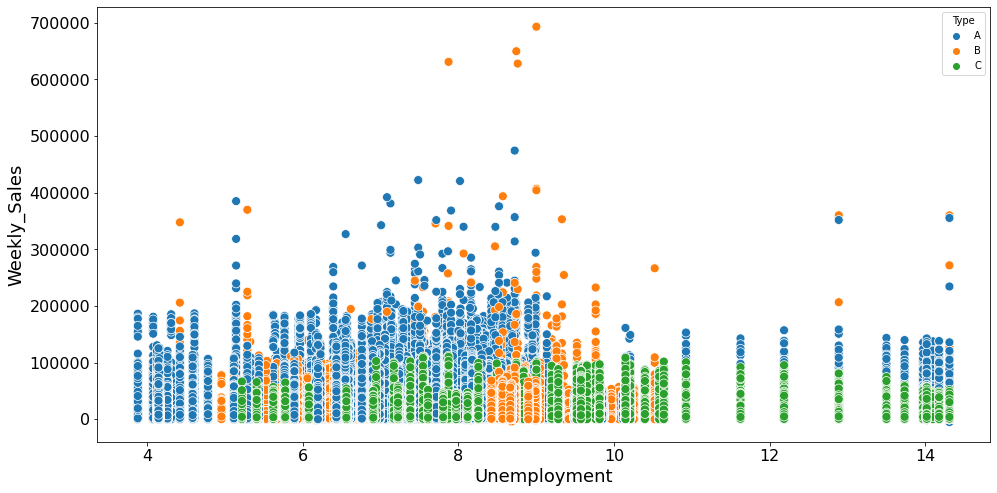

In [1051]:
# Isti je slucaj i sa atributima Unemployment i Weekly_Sales.

plt.figure(figsize=(16,8))
sns.scatterplot(x=final_data.Unemployment, y=final_data.Weekly_Sales, hue=final_data.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Unemployment', fontsize=18)
plt.ylabel('Weekly_Sales', fontsize=18);

In [1052]:
# Uklanjanje atributa Unemployment

final_data = final_data.drop(["Unemployment"], axis = 1)

In [1053]:
'''
Prikaz tipova u data set-u
Atributi Date, IsHoliday i Type moraju se transformisati.
'''

pd.DataFrame(final_data.dtypes, columns=['Type'])

,Type
Store,int64
Dept,int64
Date,object
Weekly_Sales,float64
IsHoliday,bool
Fuel_Price,float64
Type,object
Size,int64


### Kreiranje novih atributa i pretvaranje kategorickih

U opisu Kaggle takmicenja se nalaze informacije o datumima za praznike:

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [1054]:
'''
Kao sto je vec ranije receno potrebno je izvrsiti modifikaciju atributa Date ali pre toga - 
Od znacaja bi bilo kreiranje novih atributa koji ce na osnovu datuma prikazati da li je u pitanju odredjeni praznik
koji je dat u opisu ovog takmicenja kao znacajan. Atribut ce biti binaran numericki koji ce imati vrednost 1 ako
se data opservacija odnosi na taj praznik, obrnuto bice 0.
'''

def IsSuperbowl(x):
  if (x == '2010-02-12') | (x == '2011-02-11') | (x == '2012-02-10') | (x == '2013-02-08'):
    return 1
  else:
    return 0

def IsLaborday(x):
  if (x == '2010-09-10') | (x == '2011-09-09') | (x == '2012-09-07') | (x == '2013-09-06'):
    return 1
  else:
    return 0

def IsThanksgiving(x):
  if (x == '2010-11-26') | (x == '2011-11-25') | (x == '2012-11-23') | (x == '2013-11-29'):
    return 1
  else:
    return 0

def IsChristmas(x):
  if (x == '2010-12-31') | (x == '2011-12-30') | (x == '2012-12-28') | (x == '2013-12-27'):
    return 1
  else:
    return 0

final_data['IsSuperbowl'] = final_data['Date'].apply(lambda x: IsSuperbowl(x))
final_data['IsLaborday'] = final_data['Date'].apply(lambda x: IsLaborday(x))
final_data['IsThanksgiving'] = final_data['Date'].apply(lambda x: IsThanksgiving(x))
final_data['IsChristmas'] = final_data['Date'].apply(lambda x: IsChristmas(x))

In [1055]:
# Kako u test setu ne postoji podatak o prazniku Laborday novi atribut mozemo obrisati jer nam nije od znacaja

final_data.drop(['IsLaborday'], axis=1, inplace=True)

In [1056]:
'''
Kao sto je receno atribut Date je tipa object zbog toga su neophodne modifikacije ovog atributa u datetime tip
Takodje, datum kao takav nije nam previse informativan, vise nam doprinosi informacija o godini, mesecu, nedelji...
Prvo se vrsi pretvaranje u datetime tip podataka, a zatim kreiranje novih kolona koje oznacavaju dan, mesec, nedelju i godinu.
'''

final_data['Date'] = pd.to_datetime(final_data['Date'])

final_data['Day'] = final_data['Date'].dt.day
final_data['Week'] = final_data['Date'].dt.week
final_data['Month'] = final_data['Date'].dt.month
final_data['Year'] = final_data['Date'].dt.year


# Uklanjanje inicijalne kolone Date koja vise nije potrebna.

final_data.drop(['Date'], axis=1, inplace=True)

In [1057]:
final_data.head()

,Store,Dept,Weekly_Sales,IsHoliday,Fuel_Price,Type,Size,IsSuperbowl,IsThanksgiving,IsChristmas,Day,Week,Month,Year
0,1,1,24924.50,False,2.572,A,151315,0,0,0,5,5,2,2010
1,1,2,50605.27,False,2.572,A,151315,0,0,0,5,5,2,2010
2,1,3,13740.12,False,2.572,A,151315,0,0,0,5,5,2,2010
3,1,4,39954.04,False,2.572,A,151315,0,0,0,5,5,2,2010
4,1,5,32229.38,False,2.572,A,151315,0,0,0,5,5,2,2010


### II matrica korelacije nakon modifikacije datuma

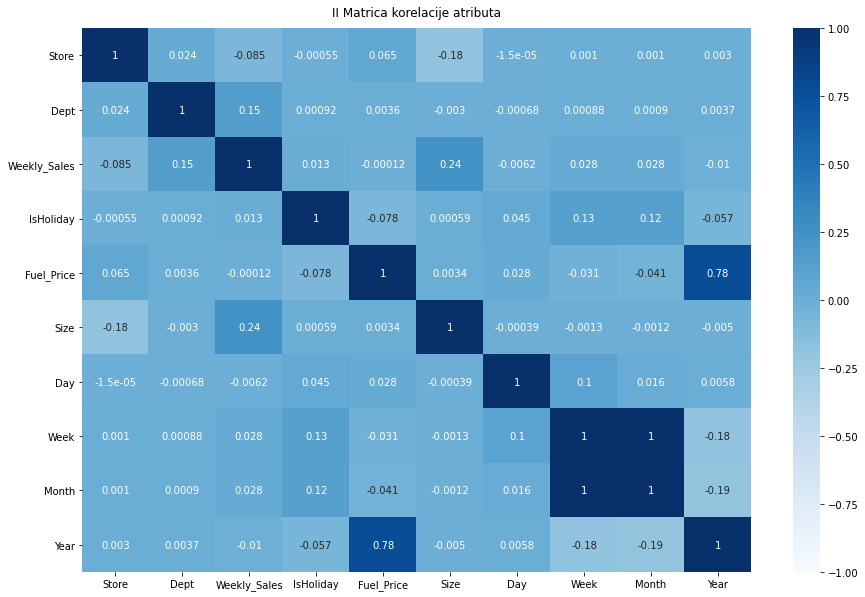

In [1058]:
plt.figure(figsize=(15, 10))

# Kako se ne bismo zbunjivali ocekivanim zavisnostima izmedju novih kategorickih vrednosti uklonicemo ih za potrebe vizualizacije

data_corr = final_data.drop(["IsSuperbowl","IsThanksgiving", "IsChristmas"], axis = 1)
heatmap = sns.heatmap(data_corr.corr(), vmin=-1, vmax=1, annot=True,cmap="Blues",annot_kws={"fontsize":10})
heatmap.set_title('II Matrica korelacije atributa', fontdict={'fontsize':12}, pad=12);

### Medju visoko korelisanim parovima atributa spadaju i cena goriva Fuel_Price i godina Year. Neka istrazivanja ("Over the past two weeks, the price of gasoline fell nearly 9 cents based on data compiled by the Lundberg Survey. The average price of gasoline in the United States is $3.3741 per gallon. Conventional wisdom holds that gasoline prices move inversely to retail sales. Thus, lower gasoline prices should mean more sales ahead for the world’s largest retailer, Wal-Mart") su pokazala da kada je cena goriva bila niza da je doslo do povecanja prodaje u Walmartu. Potrebno je ukloniti neki od ova dva atributa. Varijabla koja oznacava godinu nam je vrlo informativna pa je ne mozemo ukloniti, zbog toga cemo ukloniti Fuel_Price. Ostale korelacije nisu toliko znacajne, pa necemo uklanjati vise atributa. Neke korelacije su ocekivane kao npr Month i Week.

Text(0, 0.5, 'Fuel price')

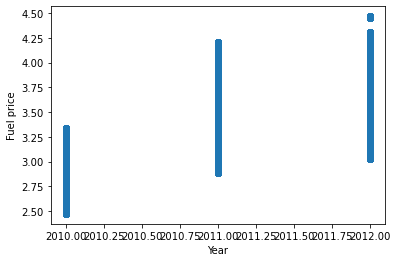

In [1059]:
plt.scatter(final_data['Year'], final_data['Fuel_Price'])

plt.xlabel('Year')
plt.ylabel('Fuel price')

In [1060]:
# Uklanjanje varibale Fuel_Price

final_data = final_data.drop(["Fuel_Price"], axis = 1)

In [1061]:
# Resen je problem sa atributom Date, a nove kolone nastale od pomenutog atributa su odgovarajuceg tipa

pd.DataFrame(final_data.dtypes, columns=['Type'])

,Type
Store,int64
Dept,int64
Weekly_Sales,float64
IsHoliday,bool
Type,object
Size,int64
IsSuperbowl,int64
IsThanksgiving,int64
IsChristmas,int64
Day,int64


In [1062]:
# Pretvaranje atributa IsHoliday u binarni numericki atribut: True - 1 False - 0

le = LabelEncoder()
final_data['IsHoliday'] = le.fit_transform(final_data['IsHoliday'])

In [1063]:
final_data['IsHoliday'].unique()

array([0, 1], dtype=int64)

In [1064]:
# Atribut Type je tipa object pa je potrebno proveriti njegove moguce vrednosti i svesti ih na jedinstvene ukoliko nisu.

final_data['Type'].value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64

In [1065]:
'''
Pretvaranje kategorickih atributa
Kolone koje su tipa object pretvaramo u numericke
Od starog atributa napravice se novi atributi i njih ce biti onoliko koliko ima mogucih vrednosti starog atributa
Novi atributi ce biti binarnog tipa - 1 i 0.
1 ako data opservacija ima vrednost tog atributa, 0 ako nema.
Primer: Od atributa Type napravice se novi atributi Type_A, Type_B i Type_C (dakle onoliko atributa koliko ima i 
mogucih kategorija tog atributa -> 3 A, B, C). Atribut Type_A bice 1 ukoliko data opservacija predstavlja prodavnicu koja je
upravo tog tipa, ukoliko nije vrednost tog atributa je 0.
'''

final_data_dummies = pd.get_dummies(final_data, columns=['Type'])

In [1066]:
final_data_dummies.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,IsSuperbowl,IsThanksgiving,IsChristmas,Day,Week,Month,Year,Type_A,Type_B,Type_C
0,1,1,24924.50,0,151315,0,0,0,5,5,2,2010,1,0,0
1,1,2,50605.27,0,151315,0,0,0,5,5,2,2010,1,0,0
2,1,3,13740.12,0,151315,0,0,0,5,5,2,2010,1,0,0
3,1,4,39954.04,0,151315,0,0,0,5,5,2,2010,1,0,0
4,1,5,32229.38,0,151315,0,0,0,5,5,2,2010,1,0,0


In [1067]:
# Sto se tice tipova atributa, cini se da su sada svi u redu

pd.DataFrame(final_data_dummies.dtypes, columns=['Type'])

,Type
Store,int64
Dept,int64
Weekly_Sales,float64
IsHoliday,int64
Size,int64
IsSuperbowl,int64
IsThanksgiving,int64
IsChristmas,int64
Day,int64
Week,int64


In [1068]:
'''
Analiza praznika
Za potrebe ovog tumacenja i mogucnosti dodavanja nove kolone, potreban nam je inicjalan skup podataka sa pretvorenim datumom
'''

data = pd.merge(train_data, features_data, on=['Store','Date','IsHoliday'], how='inner')

data_a = pd.merge(data, stores_data, on=['Store'], how='inner')

# Vec objasnjena transformacija

data_a['Date'] = pd.to_datetime(data_a['Date'])

data_a['Day'] = data_a['Date'].dt.day
data_a['Week'] = data_a['Date'].dt.week
data_a['Month'] = data_a['Date'].dt.month
data_a['Year'] = data_a['Date'].dt.year

In [1069]:
data_a.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Day,Week,Month,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,5,2,2010


### Potrebno je da ustanovimo na koje dane "padaju" praznici svake godine i da vidimo da li mozda postoji jos neki pik u prodaji za neki odredjeni dan, pa da izdvojimo i to kao bitan dan pored navedenih praznika. Takodje, potrebno je ustanoviti koliko postoji pretpraznicnih dana u nedelji. Ako odredjena nedelja ima vise pretpraznicnih dana u jednoj godini nego u nekoj drugoj, onda je vrlo verovatno da ce ta godina sa vise predpraznicnih dana imati vecu prodaju za istu nedelju nego druga godina. 

In [1070]:
data_a["Date"].max()

Timestamp('2012-10-26 00:00:00')

In [1071]:
test_data["Date"].min()

'2012-11-02'

In [1072]:
pysqldf = lambda q: sqldf(q, globals())

In [1073]:
'''
Mozemo koristiti SQL particije (zahtevaju instaliranje posebnog paketa) 
Cilj je da dobijemo za svaki praznik u godini (Super Bowl, Labor Day, Thanksgiving, Christmas) u kojoj nedelji se javlja
i na koji dan i kom data set-u pripada. Zna se da Super Bowl, Labor Day i Thanksgiving padaju na isti dan, dok je
Christmas uvek 25.decembra, pa se dan moze razlikovati (sto je i implemenirano u funkciji).
Takodje, zna se da train skup podataka sadrzi datume manje od 2012-10-26, a test ostale.
'''

pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week,
            case 
                when Date <= '2012-10-26' then 'Train Data' else 'Test Data' 
            end as Data_type
        FROM data_a
        WHERE IsHoliday = True) as T""")

,Year,Week,Data_type,Holyday,Day
0,2010,6,Train Data,Super Bowl,Sunday
1,2010,36,Train Data,Labor Day,Monday
2,2010,47,Train Data,Thanksgiving,Thursday
3,2010,52,Train Data,Christmas,Saturday
4,2011,6,Train Data,Super Bowl,Sunday
5,2011,36,Train Data,Labor Day,Monday
6,2011,47,Train Data,Thanksgiving,Thursday
7,2011,52,Train Data,Christmas,Sunday
8,2012,6,Train Data,Super Bowl,Sunday
9,2012,36,Train Data,Labor Day,Monday


#### Mozemo uvideti da svi praznici padaju uvek na isti dan. Test skup podataka ne sadrzi podatke o prazniku rada Labor Day zbog toga ovaj praznik i nece biti mnogo relevantan. 

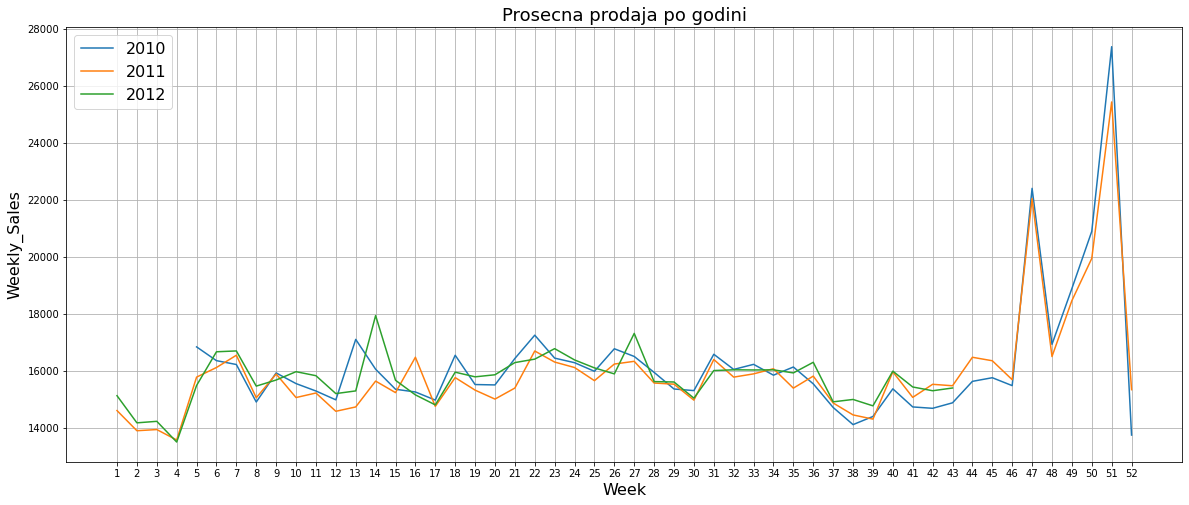

In [1074]:
'''
Sada cemo pokusati da kroz pregled prosecne prodaje po nedeljama, a kroz godine vidimo da li postoje neki pikovi u prodaji
koji su isti po godinama, a nisu obuhvaceni prethodnim praznicima.
'''

weekly_sales_2010 = data_a[data_a.Year==2010]['Weekly_Sales'].groupby(data_a['Week']).mean()
weekly_sales_2011 = data_a[data_a.Year==2011]['Weekly_Sales'].groupby(data_a['Week']).mean()
weekly_sales_2012 = data_a[data_a.Year==2012]['Weekly_Sales'].groupby(data_a['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Prosecna prodaja po godini', fontsize=18)
plt.ylabel('Weekly_Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

### Poslednji pikovi su nedelje obuhvacene praznicima, ali pikovi izmedju nedelja 13 i 16 nisu obuhvaceni praznikom u okviru ovog takmicenja. U pitanju je Uskrs, koji je 2010. godine bio u 13. nedelji, 2011. u 16.nedelji, a u 2012. u 14. Pa je potrebno postaviti da je IsHoliday za te dane 1 buduci da je prodaja u tim danima porasla, pa nam novootkriveni praznik postaje znacajan za tumacenje.

In [1075]:
final_data_dummies.loc[(final_data.Year==2010) & (final_data.Week==13), 'IsHoliday'] = 1
final_data_dummies.loc[(final_data.Year==2011) & (final_data.Week==16), 'IsHoliday'] = 1
final_data_dummies.loc[(final_data.Year==2012) & (final_data.Week==14), 'IsHoliday'] = 1

### Test

### Potrebno je odraditi iste tranformacije i nad test skupom podataka koji ce biti koriscen za dobijanje konacnih predikcija. Transformacije koje su odradjene su vec prethodno objasnjene.

In [1076]:
'''
Prikaz podataka
Isti skup podataka kao i train skup ali bez izlazne promenljive Weekly_Sales koju treba mi da predvidimo
'''

test_data.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [1077]:
# Spajanje test, features i stores skupova u podataka u jedan konacni test skup

test_features_data = pd.merge(test_data, features_data, on=['Store','Date','IsHoliday'], how='inner')

final_data_test = pd.merge(test_features_data, stores_data, on=['Store'], how='inner')

In [1078]:
final_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Date          115064 non-null  object 
 3   IsHoliday     115064 non-null  bool   
 4   Temperature   115064 non-null  float64
 5   Fuel_Price    115064 non-null  float64
 6   MarkDown1     114915 non-null  float64
 7   MarkDown2     86437 non-null   float64
 8   MarkDown3     105235 non-null  float64
 9   MarkDown4     102176 non-null  float64
 10  MarkDown5     115064 non-null  float64
 11  CPI           76902 non-null   float64
 12  Unemployment  76902 non-null   float64
 13  Type          115064 non-null  object 
 14  Size          115064 non-null  int64  
dtypes: bool(1), float64(9), int64(3), object(2)
memory usage: 13.3+ MB


In [1079]:
# Provera da li postoje nedostajuce vrednosti

final_data_test.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
dtype: int64

In [1080]:
# Detaljnija analiza NA vrednosti

null_columns = (final_data_test.isnull().sum(axis = 0)/len(final_data_test)).sort_values(ascending=False).index
null_data = pd.concat([
    final_data_test.isnull().sum(axis = 0),
    (final_data_test.isnull().sum(axis = 0)/len(final_data_test)).sort_values(ascending=False),
    final_data_test.loc[:, final_data_test.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: 'Ukupno NA vrednosti', 
                                      1: 'Procenat NA vrednosti', 
                                      2: 'Tip NA vrednosti'}).sort_values(ascending=False, by = 'Procenat NA vrednosti')
null_data = null_data[null_data["Ukupno NA vrednosti"]!=0]
null_data

,Ukupno NA vrednosti,Procenat NA vrednosti,Tip NA vrednosti
CPI,38162,0.331659,float64
Unemployment,38162,0.331659,float64
MarkDown2,28627,0.248792,float64
MarkDown4,12888,0.112007,float64
MarkDown3,9829,0.085422,float64
MarkDown1,149,0.001295,float64


<AxesSubplot:>

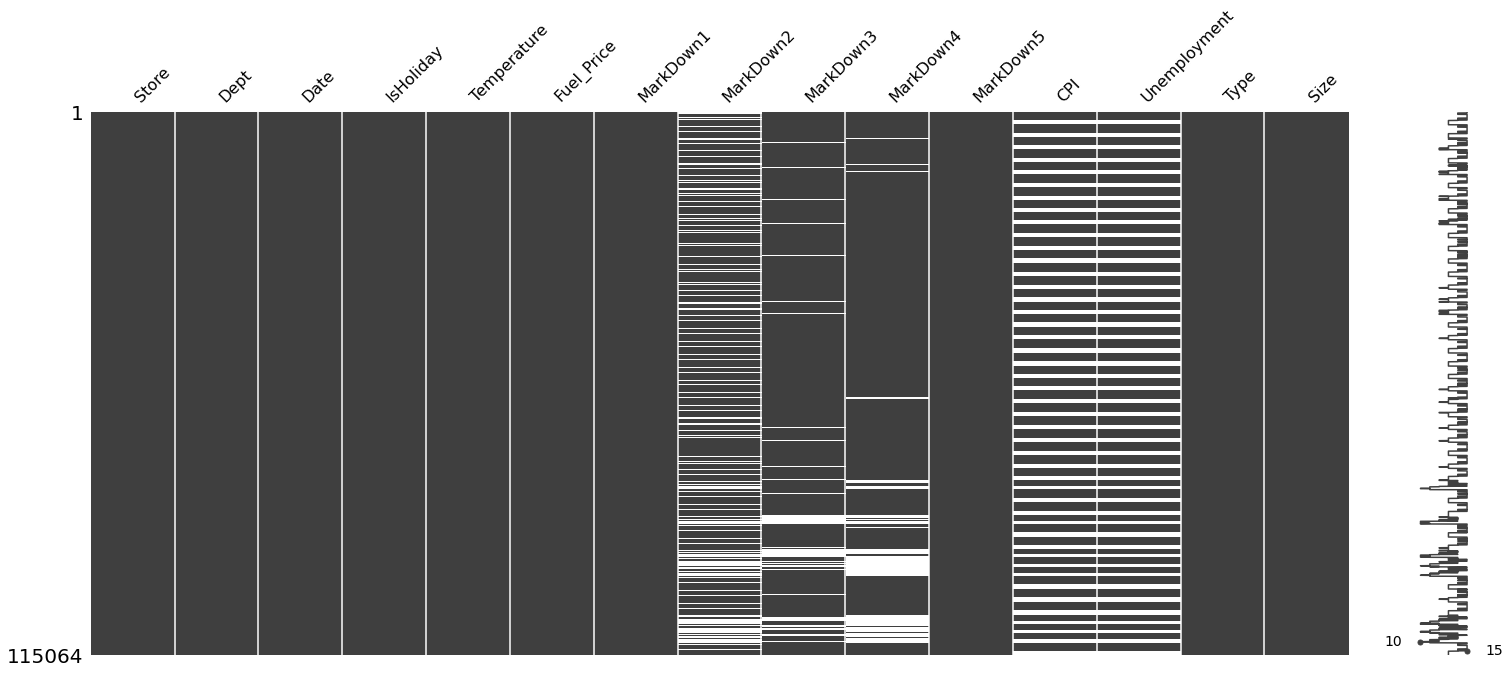

In [1081]:
msno.matrix(final_data_test)

<AxesSubplot:>

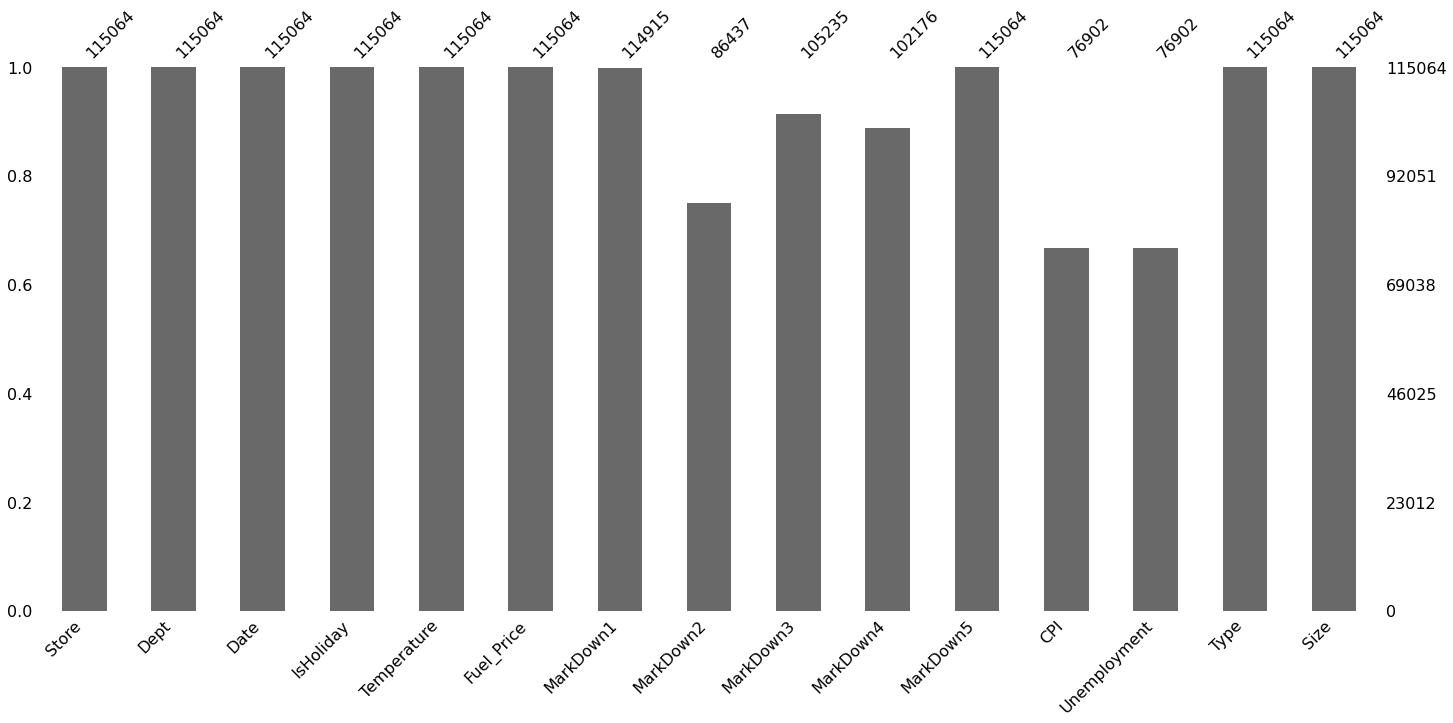

In [1082]:
msno.bar(final_data_test)

In [1083]:
final_data_test['MarkDown1'] = final_data_test['MarkDown1'].fillna(0)
final_data_test['MarkDown2'] = final_data_test['MarkDown2'].fillna(0)
final_data_test['MarkDown3'] = final_data_test['MarkDown3'].fillna(0)
final_data_test['MarkDown4'] = final_data_test['MarkDown4'].fillna(0)
final_data_test['MarkDown5'] = final_data_test['MarkDown5'].fillna(0)
final_data_test['CPI'] = final_data_test['CPI'].fillna(final_data_test['CPI'].mean())
final_data_test['Unemployment'] = final_data_test['Unemployment'].fillna(final_data_test['Unemployment'].mean())

In [1084]:
# II nacin za popunjavanje nedostajucih vrednosti za atribute CPI i Unemployment

In [1085]:
imputer = KNNImputer(n_neighbors = 3, weights = 'uniform')
final_data_test_num = final_data_test[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5', 'CPI', 'Unemployment']]

In [1086]:
final_data_test_num_t = imputer.fit_transform(final_data_test_num)

In [1087]:
final_data_test_num_t = pd.DataFrame(final_data_test_num_t, index = final_data_test_num.index , columns = final_data_test_num.columns)

In [1088]:
final_data_test_num_t.isna().sum()

MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64

In [1089]:
final_data_test['MarkDown1'] = final_data_test_num_t['MarkDown1']
final_data_test['MarkDown2'] = final_data_test_num_t['MarkDown2']
final_data_test['MarkDown3'] = final_data_test_num_t['MarkDown3']
final_data_test['MarkDown4'] = final_data_test_num_t['MarkDown4']
final_data_test['MarkDown5'] = final_data_test_num_t['MarkDown5']
final_data_test['CPI'] = final_data_test_num_t['CPI']
final_data_test['Unemployment'] = final_data_test_num_t['Unemployment']

In [1090]:
# Uklanjanje visoko korelisani atributa

final_data_test = final_data_test.drop(["MarkDown1", "MarkDown4"], axis = 1)
final_data_test = final_data_test.drop(["Fuel_Price"], axis = 1)

In [1091]:
final_data_test = final_data_test.drop(["MarkDown2", "MarkDown3", "MarkDown5"], axis = 1)
final_data_test = final_data_test.drop(["Temperature"], axis = 1)
final_data_test = final_data_test.drop(["CPI"], axis = 1)
final_data_test = final_data_test.drop(["Unemployment"], axis = 1)

In [1092]:
pd.DataFrame(final_data_test.dtypes, columns=['Type'])

,Type
Store,int64
Dept,int64
Date,object
IsHoliday,bool
Type,object
Size,int64


In [1093]:
# Pretvaranje kategorickih vrednosti

In [1094]:
def IsSuperbowl(x):
  if (x == '2010-02-12') | (x == '2011-02-11') | (x == '2012-02-10') | (x == '2013-02-08'):
    return 1
  else:
    return 0

def IsThanksgiving(x):
  if (x == '2010-11-26') | (x == '2011-11-25') | (x == '2012-11-23') | (x == '2013-11-29'):
    return 1
  else:
    return 0

def IsChristmas(x):
  if (x == '2010-12-31') | (x == '2011-12-30') | (x == '2012-12-28') | (x == '2013-12-27'):
    return 1
  else:
    return 0

final_data_test['IsSuperbowl'] = final_data_test['Date'].apply(lambda x: IsSuperbowl(x))
final_data_test['IsThanksgiving'] = final_data_test['Date'].apply(lambda x: IsThanksgiving(x))
final_data_test['IsChristmas'] = final_data_test['Date'].apply(lambda x: IsChristmas(x))

In [1095]:
final_data_test['Date'] = pd.to_datetime(final_data_test['Date'])

final_data_test['Day'] = final_data_test['Date'].dt.day
final_data_test['Week'] = final_data_test['Date'].dt.week
final_data_test['Month'] = final_data_test['Date'].dt.month
final_data_test['Year'] = final_data_test['Date'].dt.year

final_data_test.drop(['Date'], axis=1, inplace=True)

In [1096]:
pd.DataFrame(final_data_test.dtypes, columns=['Type'])

,Type
Store,int64
Dept,int64
IsHoliday,bool
Type,object
Size,int64
IsSuperbowl,int64
IsThanksgiving,int64
IsChristmas,int64
Day,int64
Week,int64


In [1097]:
final_data_test.loc[(final_data_test.Year==2013) & (final_data_test.Week==13), 'IsHoliday'] = True

In [1098]:
le = LabelEncoder()
final_data_test['IsHoliday'] = le.fit_transform(final_data_test['IsHoliday'])

In [1099]:
final_data_test['Type'].value_counts()

A    58713
B    44500
C    11851
Name: Type, dtype: int64

In [1100]:
pd.DataFrame(final_data_test.dtypes, columns=['Type'])

,Type
Store,int64
Dept,int64
IsHoliday,int64
Type,object
Size,int64
IsSuperbowl,int64
IsThanksgiving,int64
IsChristmas,int64
Day,int64
Week,int64


In [1101]:
final_data_test = pd.get_dummies(final_data_test, columns=['Type'])

In [1102]:
final_data_test.head()

,Store,Dept,IsHoliday,Size,IsSuperbowl,IsThanksgiving,IsChristmas,Day,Week,Month,Year,Type_A,Type_B,Type_C
0,1,1,0,151315,0,0,0,2,44,11,2012,1,0,0
1,1,2,0,151315,0,0,0,2,44,11,2012,1,0,0
2,1,3,0,151315,0,0,0,2,44,11,2012,1,0,0
3,1,4,0,151315,0,0,0,2,44,11,2012,1,0,0
4,1,5,0,151315,0,0,0,2,44,11,2012,1,0,0


In [1103]:
# Provera da li su isti tipovi podataka i u train skupu i u test skupu

pd.DataFrame({'Type_Train': final_data_dummies.dtypes, 'Type_Test': final_data_test.dtypes})

,Type_Train,Type_Test
Day,int64,int64
Dept,int64,int64
IsChristmas,int64,int64
IsHoliday,int64,int64
IsSuperbowl,int64,int64
IsThanksgiving,int64,int64
Month,int64,int64
Size,int64,int64
Store,int64,int64
Type_A,uint8,uint8


### Izlazni atribut Weekly_Sales

In [1104]:
'''
Uklanjanje opservacija koje imaju negativnu prodaju koja je verovatno nastala kao posledica vracanja proizvoda od strane
kupaca kojih je bilo vise nego ostvarene prodaje u toj nedelji.
Buduci da je takvih opservacija malo, mozemo ih ukloniti da ne bi dovele do pogresnih zakljucaka.
'''

final_data_dummies[final_data_dummies['Weekly_Sales'] < 0].shape

(1285, 15)

In [1105]:
final_data_dummies = final_data_dummies.drop(final_data_dummies[final_data_dummies.Weekly_Sales < 0].index)

In [1106]:
final_data_dummies.Weekly_Sales.min()

0.0

<AxesSubplot:title={'center':'Weekly Sales Histogram'}, ylabel='Frequency'>

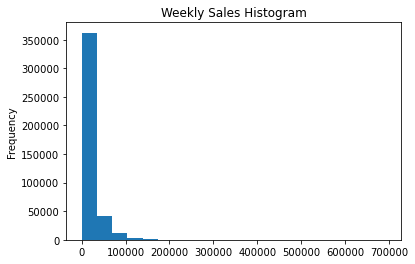

In [1107]:
'''
Provera raspodele izlaznog atributa Weekly_Sales
Raspodela je pomerena u levo i ne lici na normalnu raspodelu zbog toga je potrebno logaritmovati izlaz.
'''

final_data_dummies['Weekly_Sales'].plot(kind = "hist", title = "Weekly Sales Histogram", bins = 20)

In [1108]:
final_data_dummies.describe()['Weekly_Sales']

count    420285.000000
mean      16030.329773
std       22728.500149
min           0.000000
25%        2117.560000
50%        7659.090000
75%       20268.380000
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [1109]:
'''
Podaci ce biti podeljeni na X i y, gde y uzima samo izlazni atribut Weekly_Sales, a X sve kolone osim 
pomenutnog izlaznog atributa, dakle sve ulazne promenljive
Izlaz ce biti logaritmovan
'''

X = final_data_dummies.drop(['Weekly_Sales'], 1)
y = np.log1p(final_data_dummies['Weekly_Sales'])

<AxesSubplot:title={'center':'Weekly_Sales Histogram'}, ylabel='Frequency'>

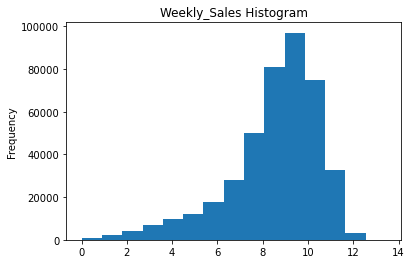

In [1110]:
# Prikaz histograma logaritmovane kolone Sales

y.plot(kind = "hist", title = "Weekly_Sales Histogram", bins = 15)

In [1111]:
X.head()

,Store,Dept,IsHoliday,Size,IsSuperbowl,IsThanksgiving,IsChristmas,Day,Week,Month,Year,Type_A,Type_B,Type_C
0,1,1,0,151315,0,0,0,5,5,2,2010,1,0,0
1,1,2,0,151315,0,0,0,5,5,2,2010,1,0,0
2,1,3,0,151315,0,0,0,5,5,2,2010,1,0,0
3,1,4,0,151315,0,0,0,5,5,2,2010,1,0,0
4,1,5,0,151315,0,0,0,5,5,2,2010,1,0,0


In [1112]:
y.head()

0    10.123647
1    10.831831
2     9.528148
3    10.595510
4    10.380665
Name: Weekly_Sales, dtype: float64

# Skaliranje

In [1113]:
'''
Skalirace se ulazne varijable kako bi podaci bili pogodiniji za primenu odredjenih algoritama.
Kolonu IsHoliday necemo skalirati zbog mere evaluacije WMAE.
'''

X["IsHoliday"]

0         0
1         0
2         0
3         0
4         0
         ..
421565    0
421566    0
421567    0
421568    0
421569    0
Name: IsHoliday, Length: 420285, dtype: int64

In [1114]:
IsHoliday_notScaled = X["IsHoliday"]

In [1115]:
# Ostale atribute cemo skalirati

X.loc[:, X.columns != 'IsHoliday']

,Store,Dept,Size,IsSuperbowl,IsThanksgiving,IsChristmas,Day,Week,Month,Year,Type_A,Type_B,Type_C
0,1,1,151315,0,0,0,5,5,2,2010,1,0,0
1,1,2,151315,0,0,0,5,5,2,2010,1,0,0
2,1,3,151315,0,0,0,5,5,2,2010,1,0,0
3,1,4,151315,0,0,0,5,5,2,2010,1,0,0
4,1,5,151315,0,0,0,5,5,2,2010,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,118221,0,0,0,26,43,10,2012,0,1,0
421566,45,94,118221,0,0,0,26,43,10,2012,0,1,0
421567,45,95,118221,0,0,0,26,43,10,2012,0,1,0
421568,45,97,118221,0,0,0,26,43,10,2012,0,1,0


In [1116]:
X_scaled = X.loc[:, X.columns != 'IsHoliday'].apply(zscore)

In [1117]:
X_scaled

,Store,Dept,Size,IsSuperbowl,IsThanksgiving,IsChristmas,Day,Week,Month,Year,Type_A,Type_B,Type_C
0,-1.657554,-1.417463,0.238806,-0.146866,-0.119794,-0.119425,-1.219484,-1.471672,-1.371932,-1.215275,0.977178,-0.795230,-0.335288
1,-1.657554,-1.384684,0.238806,-0.146866,-0.119794,-0.119425,-1.219484,-1.471672,-1.371932,-1.215275,0.977178,-0.795230,-0.335288
2,-1.657554,-1.351905,0.238806,-0.146866,-0.119794,-0.119425,-1.219484,-1.471672,-1.371932,-1.215275,0.977178,-0.795230,-0.335288
3,-1.657554,-1.319125,0.238806,-0.146866,-0.119794,-0.119425,-1.219484,-1.471672,-1.371932,-1.215275,0.977178,-0.795230,-0.335288
4,-1.657554,-1.286346,0.238806,-0.146866,-0.119794,-0.119425,-1.219484,-1.471672,-1.371932,-1.215275,0.977178,-0.795230,-0.335288
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,1.783387,1.598222,-0.303784,-0.146866,-0.119794,-0.119425,1.179744,1.213380,1.094624,1.294476,-1.023355,1.257498,-0.335288
421566,1.783387,1.631002,-0.303784,-0.146866,-0.119794,-0.119425,1.179744,1.213380,1.094624,1.294476,-1.023355,1.257498,-0.335288
421567,1.783387,1.663781,-0.303784,-0.146866,-0.119794,-0.119425,1.179744,1.213380,1.094624,1.294476,-1.023355,1.257498,-0.335288
421568,1.783387,1.729339,-0.303784,-0.146866,-0.119794,-0.119425,1.179744,1.213380,1.094624,1.294476,-1.023355,1.257498,-0.335288


In [1118]:
X_scaled["IsHoliday"] = IsHoliday_notScaled

In [1119]:
# Ista stvar uradice se i sa podacima na pravom testu koji ce biti koriscen za kreiranje konacnih predikcija

IsHoliday_notScaled_Test= final_data_test["IsHoliday"]
final_data_test_scaled = final_data_test.loc[:, final_data_test.columns != 'IsHoliday'].apply(zscore)
final_data_test_scaled["IsHoliday"] = IsHoliday_notScaled_Test

In [1120]:
# Podela na train i test, u razmeri 30% za test, 70% za train

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 1)

## Mera evaluacije

U opisu takmičenja se navodi da će se prilikom evaluacije rešenja nedelje u okviru kojih se održavaju praznici rangirati pet puta više od neprazničnih nedelja, što je je i potkrepljeno merom evaluacije gde je taj rang uključen u formulu. 
Mera evaluacije koja će biti korišćena je ponderisana srednja apsolutna greška *WMAE - Weighted Mean Absolute Error*. Potrebno je da ova mera bude sto manja da bi model bio bolji. Funkcija WMAE je:

$$WMAE = \frac{1}{\sum{w_i}}\sum_{i=1}^{n}{w_i}|y_i - {y}_i^*|$$

gde je: n broj redova tj. opservacija, yi* predvidjena vrednost prodaje, yi stvarna vrednost prodaje, Wi težine – 5 za praznicnu nedelju, 1 za ostale.
Ovo je zapravo "nadogradjena" verzija postojece mere evaluacije *MAE Mean Absolute Error* koja u sebi nema rangove Wi.         Dakle, imamo razliku izmedju stvarnog i predvidjenog izlaza za odredjenu instancu. Razlika se stavlja u apsolutnu zagradu buduci da mogu nastati greske u levu ili desnu stranu u sledecem kontekstu: ukoliko je stvarna vrednost bila 1000, a model predvidi 1001, razlika je -1; medjutim ukoliko je stvarna vrednost 1000, a predvidjena 999, onda je greska +1. Ukoliko bi se ove greske sabrale dobili smo 0. Dakle, pozitivne i negativne greske bi se potirale, zbog toga je neophodno staviti apsolutnu zagradu. Mnozimo razliku sa rangom Wi za tu instancu koji moze biti 5 ukoliko je nedelja praznicna ili 1 za ostale nedelje i zatim sumu svega za sve instance mnozimo sa kolicnikom 1 / suma svih rangova za sve instance.

In [1121]:
def WMAE(dataset, real, predicted): # ulazni parametri skup podataka, stvarna i predvidjena vrednost
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1) # lambda izraz gde se u zavisnosti od kolone IsHoliday koja oznacava da li je nedelja praznicna dodeljuju rangovi
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

### Ostale mere evaluacije

Pored pomenute mere evaluacije koja je data u opisu Kaggle takmicenja model ce biti evaluiran i sledecim drugim merama:

- *MAE - Mean Absolute Error - Srednja apsolutna greska* 
$$MAE = \frac{1}{m}\sum_{i=1}^{m}|y_i - {y}_i^*|$$
Kao sto je vec receno ova mera evaluacije je bila osnova za nastanak WMAE mere koja je vec objasnjena.


- *MSE - Mean Squared Error - Srednja kvadratna greska* 
$$MSE = \frac{1}{m}\sum_{i=1}^{m}(y_i - {y}_i^*)^{2}$$
Umesto apsolutne zagrade, ovde se koristi kvadrat u formuli sto znaci da ce nam vece greske penalizovati vise. Ako napravimo gresku 1, 1 na kvadrat je i dalje 1, ali ako napravimo gresku 5, 5 na kvadrat je 25. Ova greska ce biti veca upravo zbog kvadrata koji je prisutan u formuli. Shodno tome, imamo kvadratne jedinice, ako predvidjamo dinare to ce biti dinar na kvadrat. Taj problem nam resava sledeca mera evaluacije ubacivanjem korena koji vraca jedinice na pocetne.


- *RMSE - Root Mean Squared Error Koren srednje kvadratne greske*
$$RMSE = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(y_i - {y}_i^*)^{2}}$$


- *R^2 - Coefficient of determination Koeficijent determinacije*
$$R^2 = 1- \frac{RMSE}{VAR} \text{, gde je } VAR =\frac{1}{m}\sum_{i=1}^{m}(y_i - {y}_{mean})^2 $$
Varijansa je prosecna vrednost odstupanja od aritemticke sredine, ymean je aritemticka sredina celog skupa podataka. Ova mera nam govori koliko nas model koji smo dobili kada smo koristili ulazne atribute pravi manju gresku ili vecu u odnosu na model koji je aritmeticka sredina celog skupa podataka. (Za varijansu mozemo da kazemo da je to model gde je svaka predikcija aritemticka sredina celog skupa podataka) Sto je vrednost R2 bliza jedinici to je model bolji. Ova mera je dobra jer ne zavisi od jedinica mere kao sto je npr to problem kod MSE. 

U nastavku slede funkcije objasnjenih mera. 
Napomena - Buduci da smo izlaznu promenljivu logaritmovali potrebno je logaritam vratiti u svoju formu, obrnuto od logaritma je eksponent. Tome sluze funkcije sa prefiksom unlog.

In [1122]:
# MAE

def mae_score(y_true, y_predict):
    diff = y_true-y_predict
    diff_squared = np.abs(diff)
    mae = diff_squared.mean()
    return(mae)
    
def unlog_mae (y_true, y_predict):
    y_unlog = np.exp(y_predict) 
    mae = mae_score(y_true, y_unlog)
    return (mae)

unlog_mae = make_scorer(unlog_mae, greater_is_better=False)

In [1123]:
# MSE

def mse_score(y_true, y_predict):
    diff = y_true-y_predict
    diff_squared = np.power(diff,2)
    mse = diff_squared.mean()
    return(mse)
    
def unlog_mse (y_true, y_predict):
    y_unlog = np.exp(y_predict) 
    mse = mse_score(y_true, y_unlog)
    return (mse)

unlog_mse = make_scorer(unlog_mse, greater_is_better=False)

In [1124]:
# RMSE

def rmse_score(y_true, y_predict):
    diff = y_true-y_predict
    diff_squared = np.power(diff,2)
    mse = diff_squared.mean()
    rmse = np.sqrt(mse)
    return(rmse)

def unlog_rmse(y_true, y_predict):
    y_unlog = np.exp(y_predict) 
    rmse = rmse_score(y_true, y_unlog)
    return (rmse)

unlog_rmse = make_scorer(unlog_rmse, greater_is_better=False)

In [1125]:
# Pomocna funkcija za stampu rezultata - prosek i standardna devijacija

def error_stats(cv_dict):
    stats = {}
    for k,v in cv_dict.items(): 
        stats.update({k:(v.mean(), v.std())})
    return(stats)

In [1126]:
# Pomocna funkcija za stampanje rezultata evaluacije modela na train-u pa na test-u

def print_errors(x_train, x_test, y_train, y_test, train_pred, test_pred):
    print('WMAE (train):', WMAE(x_train, y_train, train_pred))
    print('WMAE (test):', WMAE(x_test, y_test, test_pred))

## 4. Modelovanje i evaluacija

## Linear Regression

### I model

In [1152]:
# Instanciranje modela koriscenjem funkcije LinearRegression

model_lr_1 = LinearRegression()

In [1153]:
# Ucenje modela

model_lr_1.fit(X_train, y_train)

LinearRegression()

In [1154]:
# Kreiranje predikcija na train skupu podataka

train_pred_lr_1 = model_lr_1.predict(X_train)

In [1155]:
# Kreiranje predkcija na test skupu podataka

test_pred_lr_1 = model_lr_1.predict(X_test)

In [767]:
'''
Evaluacija na train-u, zatim na test-u i stampanje rezultata
Prvo se prikazuju realne vrednosti = kada se logaritmovani izlaz to jest predikcije vrate u svoju normalnu formu,
a zatim procentualne vrednosti = bez vracanja logaritma.
Potrebno je da vrednosti gresaka budu sto manje kako bi model bio bolji
'''

print("Realna vrednost:")
print_errors(X_train, X_test, y_train, y_test, np.exp(train_pred_lr_1)-1, np.exp(test_pred_lr_1)-1) # realne vrednosti

print("\nProcentalna vrednost:")
print_errors(X_train, X_test, y_train, y_test, train_pred_lr_1, test_pred_lr_1) # logaritmovane vrednosti

Realna vrednost:
WMAE (train): 6147.87
WMAE (test): 6143.76

Procentalna vrednost:
WMAE (train): 1.44
WMAE (test): 1.43


### Medjutim, u cilju smanjenja verovatnoce lose procene zbog slucajnog izbora skupa podataka za test, bolje je primeniti cross validaciju. Ideja je da se radi testiranje vise puta, ali svaki put na razlicitom delu podataka. Dakle, na taj nacin cemo uciti model na razlicitim delovima podataka, ali i testirati na razlicitim delovima podataka.

In [768]:
'''
Evaluacija kroz kros validaciju
Mere evaluacije MAE, MSE, RMSE, R2
Prosledjujemo model, train i test skup podataka, broj foldova na koji delimo incijalni skup podataka, a zatim u scoring-u
prosledjuemo mere evaluacije koje zelimo. Sa return_train_score obezbedjujemo da se prikazu i vrednosti za train set.
'''

cv_dict = cross_validate(model_lr_1, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 
                                                                         'RMSE':unlog_rmse, 
                                                                         'MSE':unlog_mse, 
                                                                         'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.16337370872497559, 0.01425571625342514),
 'score_time': (0.019957733154296876, 0.003560192843320431),
 'test_MAE': (-6088.297371685053, 11.562743064148341),
 'train_MAE': (-6088.2299293498045, 7.380530951779619),
 'test_RMSE': (-6872.112792244135, 10.447708492528578),
 'train_RMSE': (-6872.075358251752, 8.587652716082632),
 'test_MSE': (-47226043.38393821, 143687.40860696335),
 'train_MSE': (-47225493.47727011, 118060.02942678277),
 'test_R2': (0.116576942616801, 0.0024537474549959585),
 'train_R2': (0.11673891874393741, 0.0006068321764505152)}

In [769]:
'''
Medjutim, nailazimo na problem sa merom evaluacije WMAE cija inicijalna implementacija funkcije zahteva da joj 
prosledimo dataset. Ovaj problem bice resen u nastavku na dva nacina.
'''

'\nMedjutim, nailazimo na problem sa merom evaluacije WMAE cija inicijalna implementacija funkcije zahteva da joj \nprosledimo dataset. Ovaj problem bice resen u nastavku na dva nacina.\n'

In [770]:
'''
I nacin
Kao sto je vec receno MAE je mera evaluacije koja je bila osnova za nastanak WMAE. WMAE je zapravo MAE u kojoj su instance
otezane u zavisnosti od nekog atributa to jest u ovom slucaju IsHoliday.
U osnovi te funkcije - neg_mean_absolute_error se nalazi parametar sample_weight koji nam upravo moze "pretvoriti" MAE
u WMAE. Pre toga, potrebno je tezine izracunati u posebnu promenljivu.
'''

'\nI nacin\nKao sto je vec receno MAE je mera evaluacije koja je bila osnova za nastanak WMAE. WMAE je zapravo MAE u kojoj su instance\notezane u zavisnosti od nekog atributa to jest u ovom slucaju IsHoliday.\nU osnovi te funkcije - neg_mean_absolute_error se nalazi parametar sample_weight koji nam upravo moze "pretvoriti" MAE\nu WMAE. Pre toga, potrebno je tezine izracunati u posebnu promenljivu.\n'

In [771]:
weights = X_train.IsHoliday.apply(lambda x: 5 if x else 1)

cv_dict = cross_validate(model_lr_1, X_train, y_train, cv = 5, scoring='neg_mean_absolute_error', fit_params={'sample_weight': weights}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.23893070220947266, 0.020984456731567847),
 'score_time': (0.009576368331909179, 0.001196620377391537),
 'test_score': (-1.4371058145389193, 0.0028283745047341037),
 'train_score': (-1.4369906763035876, 0.0007153849729522798)}

In [772]:
# Koriscenje unlog funkcije koja vraca logaritam u svoju formu = realne vrednosti mere evaluacije

cv_dict = cross_validate(model_lr_1, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae}, fit_params={'sample_weight': weights}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.23778038024902343, 0.007624345123844452),
 'score_time': (0.010390996932983398, 0.000789068466744482),
 'test_MAE': (-6107.436535129234, 16.419269061018202),
 'train_MAE': (-6107.261178279833, 11.323984927305892)}

In [773]:
# II nacin

In [774]:
# Prvo je potrebno izracunati tezine tj. rangove  

weights = X_train.IsHoliday.apply(lambda x: 5 if x else 1)

In [775]:
'''
Potrebno je kreirati dataframe od izlaza i tezina. Ovo je potrebno uraditi da bismo koristili index u make scoreru,
kako bi mogla da se radi cross validacija.
'''

y_frame = pd.DataFrame(y)
weights_frame = pd.DataFrame(weights)

In [776]:
def WMAE (y, y_hat, w = weights_frame):
    
    w=w.loc[y.index.values].values.reshape(-1)
    w_sum = w.sum()
    diff = np.abs(np.array(y)-y_hat)
    wmae = np.sum(w*diff)/w_sum
    
    return(wmae)

In [777]:
wm = make_scorer(WMAE, w = weights_frame, greater_is_better=False, 
                          needs_proba=False, 
                          needs_threshold=False)

In [778]:
# Primena WMAE scorera na cross validaciju

cv_dict = cross_validate(model_lr_1, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.16689205169677734, 0.01551145282470519),
 'score_time': (0.023980188369750976, 0.00500843115980519),
 'test_score': (-1.4396903141717519, 0.004433178768236097),
 'train_score': (-1.4394780510387168, 0.0015527023482873844)}

In [779]:
'''
Kao sto je vec receno ranije, buduci da smo izlaznu promenljivu logaritmovali potrebno je logaritam vratiti u svoju formu, 
obrnuto od logaritma je eksponent. Tome sluzi funkcija sa prefiksom unlog.
Nastavak istrazivanja ce se bazirati na procentualnoj vrednosti mere evaluacije, bice prikazan i postupak za kreiranje
unlog funkcije za meru evaluacije wmae (koji je isti kao i za sve prethodno definisane mere evaluacije).
'''

weights = X_train.IsHoliday.apply(lambda x: 5 if x else 1)

y_frame = pd.DataFrame(y)
weights_frame = pd.DataFrame(weights)

def WMAE(y, y_hat, w = weights_frame):
    
    w=w.loc[y.index.values].values.reshape(-1)
    w_sum = w.sum()
    diff = np.abs(np.array(y)-y_hat)
    wmae = np.sum(w*diff)/w_sum
    
    return(wmae)

def unlog_wmae(y, y_hat, w = weights_frame):
    y_unlog = np.exp(y_hat) 
    wmae = WMAE(y, y_unlog, w)
    return (wmae)

unlog_wmae = make_scorer(unlog_wmae, w = weights_frame, greater_is_better=False, 
                          needs_proba=False, 
                          needs_threshold=False)


In [780]:
# Primena WMAE scorera na cross validaciju (unlog)

cv_dict = cross_validate(model_lr_1, X_train, y_train, cv = 5, scoring = unlog_wmae, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.13633389472961427, 0.013326794038247618),
 'score_time': (0.01815786361694336, 0.003306859199996109),
 'test_score': (-6152.477555878294, 20.346148063770805),
 'train_score': (-6152.222264224427, 15.765950192284278)}

### II model selekcija atributa

In [781]:
'''
Koeficijenti su rezultat ucenja modela.
Vece vrednosti koeficijenata znaci da oni vise uticu na izlazni atribut, 
dok oni koji imaju male vrednosti imaju mali uticaj, atributi koji imaju vrednost 0 (ili blizu 0) ne uticu na izlazni atribut.
U sustini linearna regresija sama vrsi selekciju atributa buduci da daje koeficijente razlicitim atributima i na taj nacin
tretira iste, ali ce se pokusati sa sledecim nacinom selekcije atributa.
'''

model_lr_1.coef_

array([-9.30495973e-02,  5.17012910e-02,  7.21753232e-01,  1.64651530e-02,
        2.00102427e-02, -1.20669701e-02,  8.35809528e-02, -1.01718076e+00,
        1.05831850e+00, -1.31947677e-02, -5.97567685e+11, -5.82373246e+11,
       -3.60315773e+11, -7.33384843e-03])

<AxesSubplot:ylabel='att'>

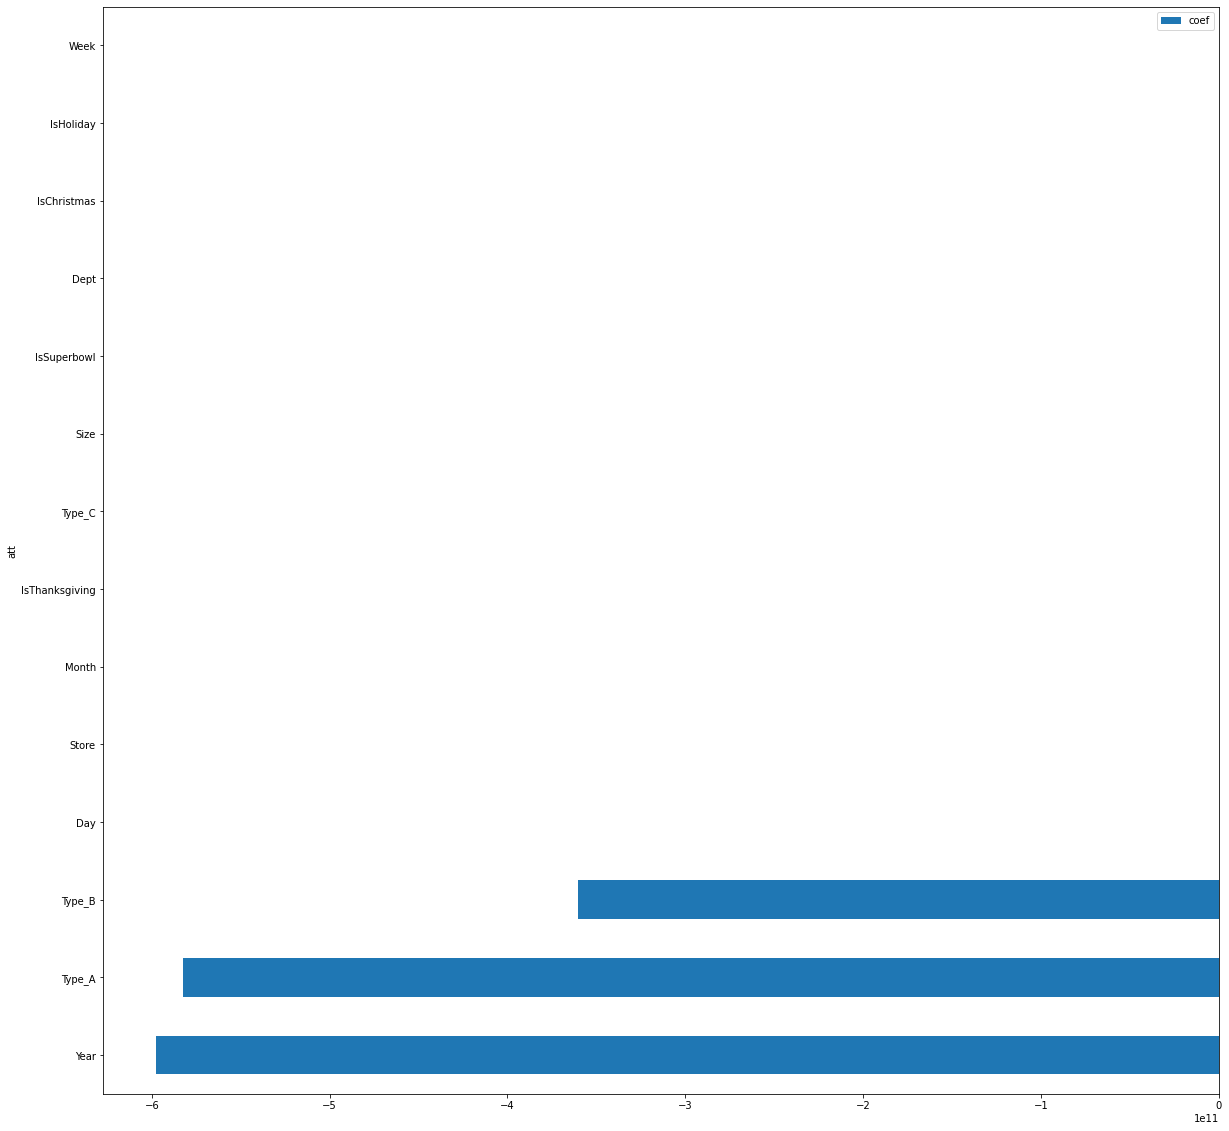

In [832]:
# Vizualizacija koeficijenata

coefs_linear = pd.DataFrame({'att':X.columns, 'coef':model_lr_1.coef_}).sort_values(by='coef',ascending=True).replace(0,np.nan).dropna()
coefs_linear.replace(0,np.nan).dropna().plot.barh(x='att', y='coef', figsize=(20, 20))

In [1138]:
'''
Biramo atribute koji imaju velike vrednosti to jest koji su sto dalji od nule. U ovom slucaju atributi imaju negativne
vrednosti pa se ocekuje losiji rezultat nakon redukcije skup ulaznih atributa, ali ce se svakako pokusati sa selekcijom da se
to i dokaze.
Atribut IsHoliday ce svakako biti uzet zbog mere evaluacije.
'''

X_train_lr = X_train[['Year', 'Type_A', 'Type_B', 'IsHoliday']]

In [1139]:
# Pravljenje novog modela koji ce uciti nad novim skupom atributa

model_lr_2 = LinearRegression()

In [1140]:
model_lr_2.fit(X_train_lr, y_train)

LinearRegression()

In [786]:
# Evaluacija WMAE

cv_dict = cross_validate(model_lr_2, X_train_lr, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.0516599178314209, 0.006225302790006688),
 'score_time': (0.016062211990356446, 0.0042572964423685375),
 'test_score': (-1.4751695007699759, 0.00727044728090175),
 'train_score': (-1.4751060864493604, 0.002361405296934163)}

In [787]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_lr_2, X_train_lr, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.058046150207519534, 0.009549790286683311),
 'score_time': (0.016563272476196288, 0.001961413440406672),
 'test_MAE': (-5590.732050639269, 8.465994661283101),
 'train_MAE': (-5590.6925073176835, 8.312749283171815),
 'test_RMSE': (-5941.397911127468, 8.038055512197074),
 'train_RMSE': (-5941.350153630373, 8.754114868170838),
 'test_MSE': (-35300273.74868626, 95532.38798280155),
 'train_MSE': (-35299718.28257078, 104050.17982619519),
 'test_R2': (0.07018246279319759, 0.0015284471577644827),
 'train_R2': (0.07024513781861123, 0.0003829504934062544)}

## Ridge Regression

### I model

In [584]:
# Instanciranje modela koriscenjem funkcije Ridge

model_rr_1 = Ridge()

In [585]:
# Ucenje modela

model_rr_1.fit(X_train, y_train)

Ridge()

In [586]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rr_1, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.08776764869689942, 0.0098157528059352),
 'score_time': (0.018352317810058593, 0.003371993360132156),
 'test_score': (-1.4397446123905877, 0.004435065556076708),
 'train_score': (-1.439536284882378, 0.0015623558143874076)}

In [587]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rr_1, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.09813895225524902, 0.007513123549942474),
 'score_time': (0.021610450744628907, 0.0009850313775018884),
 'test_MAE': (-6084.928700631417, 14.455307311712136),
 'train_MAE': (-6084.835123987248, 8.883449335884599),
 'test_RMSE': (-6866.579662955848, 14.990328826343008),
 'train_RMSE': (-6866.507731819182, 11.171412958102305),
 'test_MSE': (-47150140.97767716, 205950.88047171946),
 'train_MSE': (-47149053.23160009, 153491.84810805647),
 'test_R2': (0.11658710728662444, 0.0024446996571114623),
 'train_R2': (0.11673951190838863, 0.0006067115530473062)}

### II model selekcija atributa

In [588]:
model_rr_1.coef_

array([-0.09139709,  0.05175397,  0.72179992,  0.01628083,  0.01991496,
       -0.01197529,  0.06907941, -0.85294577,  0.89463203, -0.01505768,
       -0.08732374,  0.12554682, -0.05809699, -0.00760894])

<AxesSubplot:ylabel='att'>

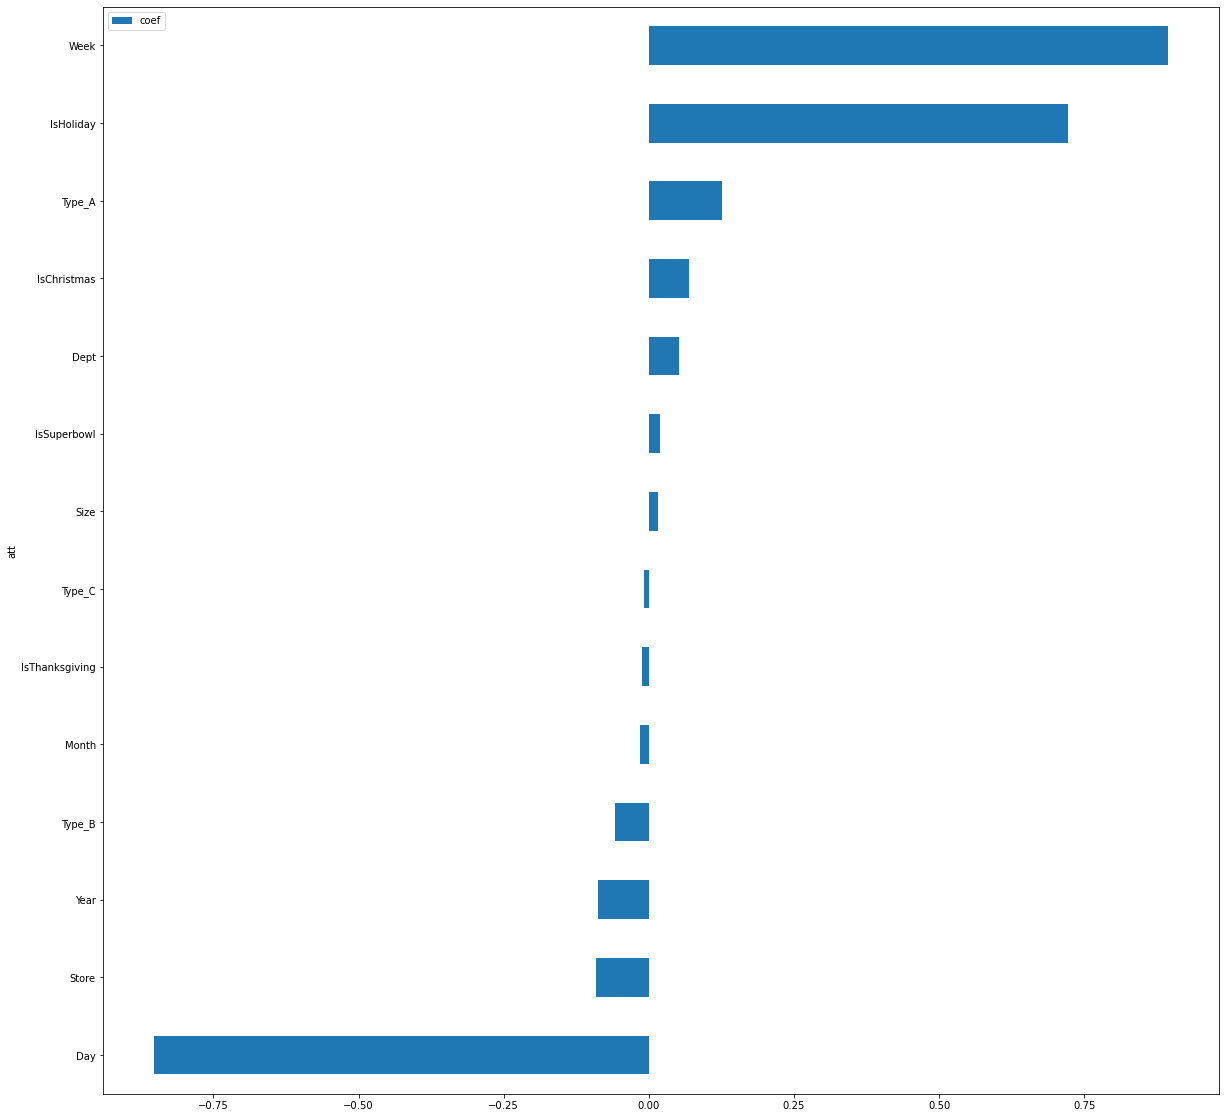

In [589]:
coefs_linear = pd.DataFrame({'att':X.columns, 'coef':model_rr_1.coef_}).sort_values(by='coef',ascending=True).replace(0,np.nan).dropna()
coefs_linear.replace(0,np.nan).dropna().plot.barh(x='att', y='coef', figsize=(20, 20))

In [1212]:
X_train_rr = X_train[['IsHoliday','Week', 'Type_A', 'Day', 'Store']]

In [1213]:
model_rr_2 = Ridge()

In [1214]:
model_rr_2.fit(X_train_rr, y_train)

Ridge()

In [1215]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rr_2, X_train_rr, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.033976173400878905, 0.00467067841780004),
 'score_time': (0.015468883514404296, 0.005688944150754001),
 'test_score': (-1.5092142690241492, 0.00742532617904658),
 'train_score': (-1.5091620145050006, 0.0025380301381944933)}

In [604]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rr_2, X_train_rr, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.04468178749084473, 0.005023915849423628),
 'score_time': (0.015358829498291015, 0.0010166109234314939),
 'test_MAE': (-5588.702449367463, 14.298736177959345),
 'train_MAE': (-5588.6506359213945, 10.009897161324067),
 'test_RMSE': (-6154.489991807632, 19.36771103799111),
 'train_RMSE': (-6154.406885165365, 12.394458438971606),
 'test_MSE': (-37878122.16749116, 238260.67811953335),
 'train_MSE': (-37876877.73077085, 152602.23905976585),
 'test_R2': (0.05303959315433027, 0.0010783777190628242),
 'train_R2': (0.05308771312493823, 0.0002668262308232514)}

## III model optimizacija parametara

## alpha

In [605]:
rr_params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
for i in rr_params:
    rr = Ridge(alpha=i)
    wmae = np.mean(cross_val_score(rr, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

0.1 -1.4397374041256217
0.2 -1.4397383201685536
0.3 -1.4397392041701937
0.4 -1.4397400536064962
0.5 -1.4397408731247783
0.6 -1.4397416700556263
0.7 -1.4397424402657675


In [857]:
model_rr_3 = Ridge(alpha = 0.1)

In [858]:
model_rr_3.fit(X_train, y_train)

Ridge(alpha=0.1)

In [790]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rr_3, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.09599266052246094, 0.011501094459215969),
 'score_time': (0.0193575382232666, 0.0025717218654282706),
 'test_score': (-1.4397374041256217, 0.004437289892621577),
 'train_score': (-1.439527456542825, 0.0015612492863345373)}

In [791]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rr_3, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.08703837394714356, 0.014174372348981988),
 'score_time': (0.018984031677246094, 0.0026050295350395687),
 'test_MAE': (-6084.976995222734, 14.451432079742345),
 'train_MAE': (-6084.885479115556, 8.886574743377016),
 'test_RMSE': (-6866.67211903688, 14.993230625371497),
 'train_RMSE': (-6866.606405310689, 11.191865265572535),
 'test_MSE': (-47151410.787323005, 205993.44980750853),
 'train_MSE': (-47150408.783301905, 153775.8040977228),
 'test_R2': (0.11658381291894664, 0.0024481678550270967),
 'train_R2': (0.11673992849211015, 0.000606814410446075)}

## IV model optimizacija parametara + selekcija atributa

In [792]:
model_rr_4 = Ridge(alpha = 0.1)

In [793]:
model_rr_4.fit(X_train_rr, y_train)

Ridge(alpha=0.1)

In [794]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rr_4, X_train_rr, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.04145770072937012, 0.006997797714856513),
 'score_time': (0.01477346420288086, 0.005012869698769247),
 'test_score': (-1.5003804338466473, 0.007034449946499694),
 'train_score': (-1.5003139670326706, 0.0023563745679935663)}

In [795]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rr_4, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.08999786376953126, 0.011994674088165928),
 'score_time': (0.02054705619812012, 0.0036022679972545265),
 'test_MAE': (-6084.976995222734, 14.451432079742345),
 'train_MAE': (-6084.885479115556, 8.886574743377016),
 'test_RMSE': (-6866.67211903688, 14.993230625371497),
 'train_RMSE': (-6866.606405310689, 11.191865265572535),
 'test_MSE': (-47151410.787323005, 205993.44980750853),
 'train_MSE': (-47150408.783301905, 153775.8040977228),
 'test_R2': (0.11658381291894664, 0.0024481678550270967),
 'train_R2': (0.11673992849211015, 0.000606814410446075)}

## Decision Tree Regressor

### I model

In [796]:
# Instanciranje modela koriscenjem funkcije DecisionTreeRegressor

model_dt_1 = DecisionTreeRegressor()

In [797]:
model_dt_1.fit(X_train, y_train)

DecisionTreeRegressor()

In [798]:
# Evaluacija WMAE

cv_dict = cross_validate(model_dt_1, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (1.7307598114013671, 0.08349985142273719),
 'score_time': (0.04707212448120117, 0.0011440031642703757),
 'test_score': (-0.23492330008193005, 0.002524834104285538),
 'train_score': (-5.988172631771326e-20, 3.8900223064819225e-20)}

In [799]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_dt_1, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (1.6817307949066163, 0.037061810333277094),
 'score_time': (0.05155000686645508, 0.00522279238859529),
 'test_MAE': (-15997.414221638737, 56.0732681574497),
 'train_MAE': (-15996.260442869889, 14.98689261367374),
 'test_RMSE': (-27797.972270878636, 125.02235720989884),
 'train_RMSE': (-27773.23935926565, 46.44023165087948),
 'test_MSE': (-772742892.9623401, 6945812.788340946),
 'train_MSE': (-771354981.2021785, 2580805.974973156),
 'test_R2': (0.9528289230645136, 0.0013056185169612003),
 'train_R2': (1.0, 0.0)}

## II model optimizacija parametara

## 1. optimizacija

In [1363]:
'''
Optimizacija parametara algoritma:
max_features = maksimalan broj atributa koji se uzimaju u obzir prilikom grananja; 
min_samples_leaf = minimalan broj slucajeva koji mora postojati u svakom listu
max_depth = maksimalna dubina stabla
min_samples_split = minimalan broj slucajeva da bi se cvor granao dalje
'''

decision_tree_params = {'max_features': [1, 2, 4], 
                        'min_samples_leaf': [3, 5, 7],
                        'max_depth': [5, 10, 15], 
                        'min_samples_split': [4, 6, 8]}
grid_dt = GridSearchCV(DecisionTreeRegressor(), decision_tree_params, cv=10, scoring = 'neg_root_mean_squared_error')
grid_dt.fit(X,y)

print('Best param: ', grid_dt.best_params_)

Best param:  {'max_depth': 15, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 6}


In [945]:
# Optimizovan model

model_dt_2 = DecisionTreeRegressor(max_depth = 15, max_features = 4, min_samples_leaf = 5, min_samples_split = 6)

In [946]:
model_dt_2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15, max_features=4, min_samples_leaf=5,
                      min_samples_split=6)

In [1382]:
# Evaluacija WMAE

cv_dict = cross_validate(model_dt_2, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.428143310546875, 0.04241598352117196),
 'score_time': (0.025533485412597656, 0.002848665812151228),
 'test_score': (-0.9713978384554001, 0.0421658492978801),
 'train_score': (-0.8996042902111258, 0.03116027655034588)}

In [1383]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_dt_2, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.41014842987060546, 0.03609219049265479),
 'score_time': (0.030380439758300782, 0.004116479403677795),
 'test_MAE': (-11222.492710923489, 959.863016051636),
 'train_MAE': (-11250.756480961976, 969.0414900640284),
 'test_RMSE': (-18918.37168984171, 2113.899078596452),
 'train_RMSE': (-19001.570505926404, 2118.444556690543),
 'test_MSE': (-362373356.7094952, 80207080.05587184),
 'train_MSE': (-365547489.031464, 80852754.59609431),
 'test_R2': (0.5003351174959203, 0.08445613379656126),
 'train_R2': (0.5486425001947213, 0.0756055403770615)}

## III model optimizacija parametara

## 2. optimizacija

## max_features

In [228]:
dt_params = [1, 2, 4, 5, 6]
for i in dt_params:
    dt = DecisionTreeRegressor(max_features=i)
    wmae = np.mean(cross_val_score(dt, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

1 -1.4419810231582617
2 -1.4073166546936906
4 -0.9684526289254259
5 -0.9086520487703682
6 -0.6438263388815901


## min_samples_leaf

In [230]:
dt_params = [3, 5, 7, 9, 11]
for i in dt_params:
    dt = DecisionTreeRegressor(min_samples_leaf=i)
    wmae = np.mean(cross_val_score(dt, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

3 -0.21675040542818796
5 -0.21434670662480265
7 -0.2159120620116975
9 -0.21863565885382363
11 -0.22237853829220805


## max_depth

In [456]:
dt_params = [5, 7, 10, 13, 15]
for i in dt_params:
    dt = DecisionTreeRegressor(max_depth=i)
    wmae = np.mean(cross_val_score(dt, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

5 -1.0877353301619077
7 -0.8676993025834576
10 -0.4958845400576105
13 -0.3222210452134099
15 -0.26623490393425947


## min_samples_split

In [234]:
dt_params = [2, 4, 6, 8]
for i in dt_params:
    dt = DecisionTreeRegressor(min_samples_split=i)
    wmae = np.mean(cross_val_score(dt, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

2 -0.2347024178388774
4 -0.2281683447776249
6 -0.22244145445202718
8 -0.21965459615370403


In [217]:
model_dt_3 = DecisionTreeRegressor(max_depth = 15, max_features = 6, min_samples_leaf = 5, min_samples_split = 8)

In [218]:
model_dt_3.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15, max_features=6, min_samples_leaf=5,
                      min_samples_split=8)

In [219]:
# Evaluacija WMAE

cv_dict = cross_validate(model_dt_3, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.5100196361541748, 0.045361920677122865),
 'score_time': (0.02374558448791504, 0.00040373854278372254),
 'test_score': (-0.7641694674555785, 0.06515044606597552),
 'train_score': (-0.7050437242782712, 0.0588925618199608)}

In [220]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_dt_3, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.5571228981018066, 0.046618739532629586),
 'score_time': (0.02851243019104004, 0.0027282657080854268),
 'test_MAE': (-12937.735910195112, 507.98721798059285),
 'train_MAE': (-12973.261965810514, 495.8924668349139),
 'test_RMSE': (-22761.081379166262, 870.8644371354404),
 'train_RMSE': (-22865.671072971763, 880.2487797193986),
 'test_MSE': (-518825230.41689646, 39402965.2237591),
 'train_MSE': (-523613751.53153515, 39963684.784707464),
 'test_R2': (0.6362955663856613, 0.04965115725092938),
 'train_R2': (0.6748777252443723, 0.048199402255822754)}

In [1235]:
max_depth_params = [5, 7, 10]
max_features_params = [1, 2, 3]

for i in max_depth_params:
    for j in max_features_params:
        dt = DecisionTreeRegressor(max_depth=i, max_features=j)
        wmae = np.mean(cross_val_score(dt, X_train, y_train, cv=5, scoring=wm))
        print(i, j, wmae)

5 1 -1.4187916551546218
5 2 -1.352287375270968
5 3 -1.3160172276990891
7 1 -1.432471712759027
7 2 -1.3473479449178787
7 3 -1.31184535749758
10 1 -1.2938250661724122
10 2 -1.2680660360553226
10 3 -1.2029744466911065


## IV model selekcija atributa + optimizovani parametri

### Selekcija atributa model 2 (model_dt_2)

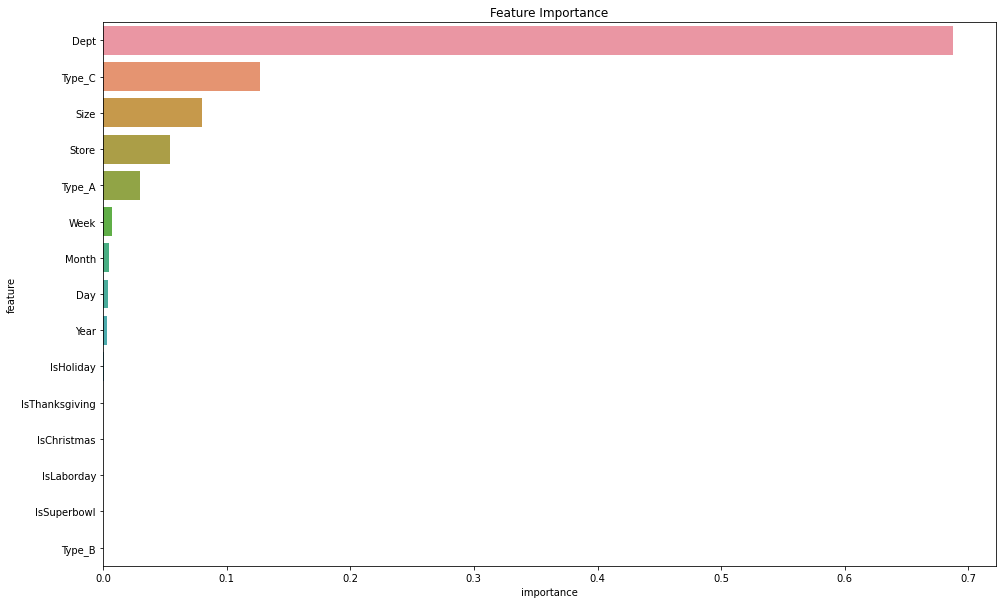

In [180]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_dt_2.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(16,10))
plt.title('Feature Importance')
sns.barplot(data=importance_df, x='importance', y='feature');

In [221]:
X_train_dt = X_train[['Dept','Type_C', 'Size', 'Store', 'IsHoliday']]

In [222]:
model_dt_4 = DecisionTreeRegressor(max_depth = 15, max_features = 4, min_samples_leaf = 5, min_samples_split = 6)

In [223]:
model_dt_4.fit(X_train_dt, y_train)

DecisionTreeRegressor(max_depth=15, max_features=4, min_samples_leaf=5,
                      min_samples_split=6)

In [224]:
# Evaluacija WMAE

cv_dict = cross_validate(model_dt_4, X_train_dt, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.31793937683105467, 0.021469642957134792),
 'score_time': (0.019549131393432617, 0.0007971130331792721),
 'test_score': (-0.3773040524630815, 0.020067218480337098),
 'train_score': (-0.36282002113201234, 0.021086785260027375)}

In [225]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_dt_4, X_train_dt, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.3131698131561279, 0.007692391006153652),
 'score_time': (0.02294011116027832, 0.0012637204129105017),
 'test_MAE': (-15251.005513303196, 43.61439830909618),
 'train_MAE': (-15250.539594304337, 37.48585949697087),
 'test_RMSE': (-26116.615717250654, 140.28103609232096),
 'train_RMSE': (-26121.019854899787, 55.41890934825976),
 'test_MSE': (-682097295.2916311, 7341086.887946236),
 'train_MSE': (-682310749.5155822, 2894447.1524750553),
 'test_R2': (0.9000250160920558, 0.007878264300342757),
 'train_R2': (0.9047481181068109, 0.0066971793005712035)}

## V model selekcija atributa + optimizovani parametri

### Selekcija atributa model 1 (model_dt_1)

In [1179]:
model_dt_1.feature_importances_

array([6.77614840e-02, 7.14761462e-01, 1.28174544e-01, 1.81675980e-04,
       2.78782272e-04, 2.21929301e-04, 8.72377453e-03, 3.57640639e-02,
       3.84890050e-03, 9.74175553e-03, 2.29628428e-03, 2.52361265e-02,
       1.48478674e-03, 1.52443042e-03])

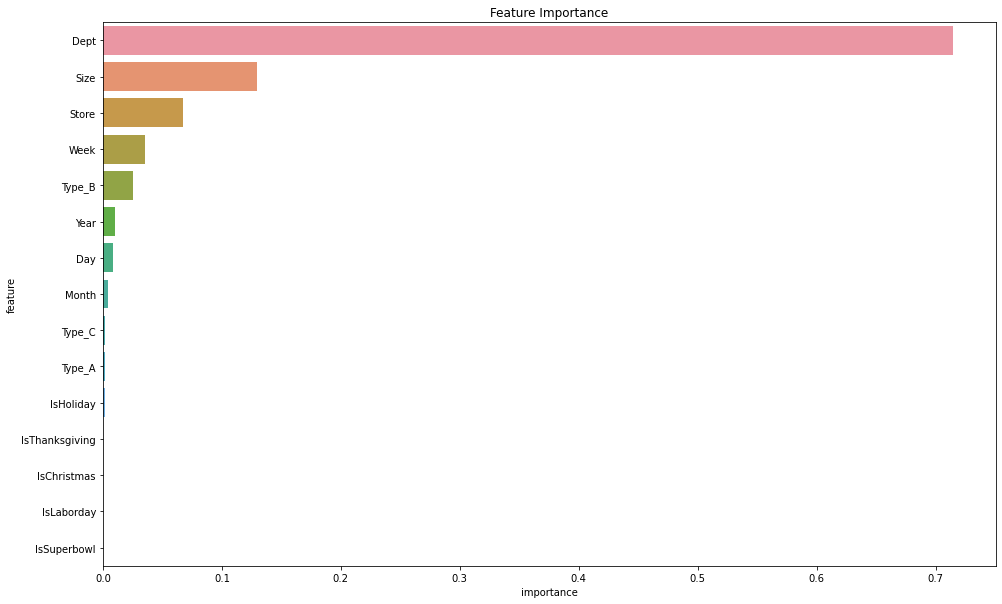

In [188]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_dt_1.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(16,10))
plt.title('Feature Importance')
sns.barplot(data=importance_df, x='importance', y='feature');

In [1190]:
X_train_dt = X_train[['Dept', 'Size', 'Store', 'Week']]

In [1198]:
model_dt_5 = DecisionTreeRegressor(max_depth = 15, max_features = 4, min_samples_leaf = 5, min_samples_split = 6)

In [1199]:
model_dt_5.fit(X_train_dt, y_train)

DecisionTreeRegressor(max_depth=15, max_features=4, min_samples_leaf=5,
                      min_samples_split=6)

In [1193]:
# Evaluacija WMAE

cv_dict = cross_validate(model_dt_5, X_train_dt, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.5003705978393554, 0.008926874555000153),
 'score_time': (0.01875591278076172, 0.006243735747500529),
 'test_score': (-0.2882417050092796, 0.0014999592985586677),
 'train_score': (-0.2611881941295075, 0.000649157949742778)}

In [1194]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_dt_5, X_train_dt, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.5014991283416748, 0.004407145758088768),
 'score_time': (0.021858072280883788, 0.007638902083113731),
 'test_MAE': (-15619.533861698215, 60.19456427120105),
 'train_MAE': (-15620.094340661477, 16.21041042569052),
 'test_RMSE': (-26861.789782913205, 102.65823875827914),
 'train_RMSE': (-26865.035466238634, 43.03462988725474),
 'test_MSE': (-721566289.0554053, 5510271.694833252),
 'train_MSE': (-721731982.5816294, 2313135.297097383),
 'test_R2': (0.9404697685760878, 0.0005831408789887039),
 'train_R2': (0.9517686293246163, 0.00037979470423932997)}

## VI model selekcija atributa + optimizovani parametri

In [925]:
X_train_dt = X_train[['Dept','Type_C', 'Size', 'Store', 'Type_A', 'IsHoliday']]

In [926]:
model_dt_6 = DecisionTreeRegressor(max_depth = 15, max_features = 6, min_samples_leaf = 5, min_samples_split = 8)

In [927]:
model_dt_6.fit(X_train_dt, y_train)

DecisionTreeRegressor(max_depth=15, max_features=6, min_samples_leaf=5,
                      min_samples_split=8)

In [815]:
# Evaluacija WMAE

cv_dict = cross_validate(model_dt_6, X_train_dt, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.4307409763336182, 0.020258854835688657),
 'score_time': (0.020629739761352538, 0.0009785899986428),
 'test_score': (-0.33933321052489285, 0.001648037318621307),
 'train_score': (-0.3252886714510626, 0.0004830096606328394)}

In [816]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_dt_6, X_train_dt, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.4208122730255127, 0.017962321240676173),
 'score_time': (0.022889041900634767, 0.000671727506482338),
 'test_MAE': (-15317.289207491782, 56.577320512153264),
 'train_MAE': (-15314.499190093149, 13.871019394213851),
 'test_RMSE': (-26155.57200937745, 111.2190785308842),
 'train_RMSE': (-26152.218432045815, 34.50058351143014),
 'test_MSE': (-684126316.8211584, 5828402.015573227),
 'train_MSE': (-683939719.2076995, 1805302.0988173233),
 'test_R2': (0.9104096588901498, 0.0013272411989107271),
 'train_R2': (0.9149606841242732, 0.0006070921634758464)}

## KNeighborsRegressor

## I model

In [817]:
# Instanciranje modela koriscenjem funkcije KNeighborsRegressor

model_knn_1 = KNeighborsRegressor()

In [818]:
# Ucenje modela

model_knn_1.fit(X_train, y_train)

KNeighborsRegressor()

In [1394]:
# Evaluacija WMAE

cv_dict = cross_validate(model_knn_1, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (274.9907025337219, 24.444158717024358),
 'score_time': (164.26641435623168, 6.591260660609226),
 'test_score': (-1.2280911738446034, 0.0038852388302705603),
 'train_score': (-0.9963557405108316, 0.0013339321782071807)}

In [1395]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_lr_2, X_train_lr, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.04554557800292969, 0.005963462539076187),
 'score_time': (0.01535344123840332, 0.00400855018811289),
 'test_MAE': (-5590.732050639269, 8.465994661283101),
 'train_MAE': (-5590.6925073176835, 8.312749283171815),
 'test_RMSE': (-5941.397911127468, 8.038055512197074),
 'train_RMSE': (-5941.350153630373, 8.754114868170838),
 'test_MSE': (-35300273.74868626, 95532.38798280155),
 'train_MSE': (-35299718.28257078, 104050.17982619519),
 'test_R2': (0.07018246279319759, 0.0015284471577644827),
 'train_R2': (0.07024513781861123, 0.0003829504934062544)}

## II model optimizacija parametara

## 1. optimizacija

In [154]:
# Optimizacija parametara algoritma: n_neighbors = broj suseda

knn_params = {'n_neighbors': range(3,11)}
grid_knn = GridSearchCV(KNeighborsRegressor(), knn_params, cv=10, scoring = 'neg_root_mean_squared_error')
grid_knn.fit(X,y)

print('Best param: ', grid_knn.best_params_)

Best param:  {'n_neighbors': 10}


In [819]:
model_knn_2 = KNeighborsRegressor(n_neighbors=10)

In [1397]:
model_knn_2.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [1398]:
# Evaluacija WMAE

cv_dict = cross_validate(model_knn_2, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (249.42290978431703, 7.8341057720869625),
 'score_time': (173.04286942481994, 2.760602319149439),
 'test_score': (-1.19917276608389, 0.005626721835536311),
 'train_score': (-1.0831253458531702, 0.0013461502607904732)}

In [328]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_knn_2, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (282.40459446907045, 23.20506914315535),
 'score_time': (167.66529178619385, 12.71487210439724),
 'test_MAE': (-11528.1712920776, 30.671049365962162),
 'train_MAE': (-15996.260442869889, 14.98689261367374),
 'test_RMSE': (-18556.867204540533, 57.811532443652695),
 'train_RMSE': (-27773.23935926565, 46.44023165087948),
 'test_MSE': (-344360662.6202353, 2147512.0489170323),
 'train_MSE': (-771354981.2021785, 2580805.974973156),
 'test_R2': (0.22141261418931482, 0.0032633342389791074),
 'train_R2': (1.0, 0.0)}

## III model optimizacija parametara

## 2. optimizacija

In [1401]:
## II vrsta optimizacije

knn_params= {
    'n_neighbors' : [3, 5, 11, 19],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan']
}

gs = GridSearchCV (
     KNeighborsRegressor(),
     knn_params,
     verbose = 1,
     cv = 3,
     n_jobs = -1
)

model_knn_3 = gs.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 187.1min finished


In [1402]:
model_knn_3.best_params_

{'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}

In [474]:
model_knn_3 = KNeighborsRegressor(n_neighbors=19, metric = 'euclidean', weights = 'uniform')

In [476]:
model_knn_3.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=19)

In [477]:
# Evaluacija WMAE

cv_dict = cross_validate(model_knn_4, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (254.47214913368225, 3.7548260712531643),
 'score_time': (188.90793828964235, 2.501504554737276),
 'test_score': (-1.1896454617385799, 0.005761975444625796),
 'train_score': (-1.1283348388468188, 0.0014179909823639593)}

In [481]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_knn_4, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (258.1580234527588, 14.56266727288877),
 'score_time': (189.17450361251832, 0.9470443659180017),
 'test_MAE': (-8825.373555445036, 15.842749984007511),
 'train_MAE': (-8887.625361084982, 14.35003648820538),
 'test_RMSE': (-12497.9148013959, 30.239372997893838),
 'train_RMSE': (-12621.26745369398, 19.076688994398268),
 'test_MSE': (-156198788.80263004, 756326.1355849528),
 'train_MSE': (-159296756.05773792, 481856.36306544003),
 'test_R2': (0.3391116825225363, 0.004405853109388749),
 'train_R2': (0.4058262445520329, 0.0010585466124981581)}

## IV model optimizacija parametara

## 3. optimizacija

In [236]:
knn_params = [3, 4, 5, 6, 7, 8, 9, 10, 11]
for i in knn_params:
    knn = KNeighborsRegressor(n_neighbors=i)
    wmae = np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

3 -1.2747402161319
4 -1.2439102196778709
5 -1.2280911738446034
6 -1.2195633132821933
7 -1.212390032549188
8 -1.2071848080943477
9 -1.2023194731101716
10 -1.19917276608389
11 -1.1961647851530648


In [483]:
knn_params = [16, 18, 20, 22, 24, 26]
for i in knn_params:
    knn = KNeighborsRegressor(n_neighbors=i)
    wmae = np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

16 -1.1904912614630523
18 -1.1898872388273154
20 -1.1897574725107853
22 -1.1908331586641254
24 -1.1914785624009965
26 -1.1917222687384812


In [861]:
model_knn_4 = KNeighborsRegressor(n_neighbors=20)

In [862]:
model_knn_4.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20)

In [486]:
# Evaluacija WMAE

cv_dict = cross_validate(model_knn_4, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (265.50787963867185, 17.862985503692137),
 'score_time': (194.69220781326294, 5.415431887949554),
 'test_score': (-1.1897574725107853, 0.005974315148754556),
 'train_score': (-1.1313344904263887, 0.0015005221245219967)}

In [488]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_knn_4, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (254.3031017780304, 7.940116235495134),
 'score_time': (189.18183541297913, 1.3416223582985893),
 'test_MAE': (-8774.095913022056, 15.156545366112496),
 'train_MAE': (-8831.548489959094, 13.692922295653707),
 'test_RMSE': (-12380.886472695187, 31.677671960637003),
 'train_RMSE': (-12492.993594158723, 18.330225608455684),
 'test_MSE': (-153287353.3246675, 785286.0905347054),
 'train_MSE': (-156075224.94086173, 458396.62307209807),
 'test_R2': (0.3395904706723831, 0.004503181872293743),
 'train_R2': (0.4029862951779579, 0.0011362982615262408)}

## V model optimizacija parametara

## 4. optimizacija

### weights

In [249]:
knn_params = ['uniform', 'distance']
for i in knn_params:
    knn = KNeighborsRegressor(weights=i)
    wmae = np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

uniform -1.2280911738446034
distance -1.2591794446133904


### metric

In [251]:
knn_params = ['euclidean', 'manhattan', 'chebyshev', 'mahalanobis', 'minkowski']
for i in knn_params:
    knn = KNeighborsRegressor(metric=i)
    wmae = np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

euclidean -1.2280911738446034
manhattan -1.2309081477325154
chebyshev -1.2487583582862511
mahalanobis nan
minkowski -1.2280911738446034


In [261]:
model_knn_4 = KNeighborsRegressor(weights = 'uniform', metric = 'euclidean')

In [262]:
model_knn_4.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean')

In [263]:
# Evaluacija WMAE

cv_dict = cross_validate(model_knn_4, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (245.79037113189696, 0.5581006927531268),
 'score_time': (156.3072358608246, 0.9290718869977334),
 'test_score': (-1.2280911738446034, 0.0038852388302705603),
 'train_score': (-0.9963557405108316, 0.0013339321782071807)}

In [264]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_knn_4, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (279.4948830604553, 54.13906859192976),
 'score_time': (169.2891230583191, 21.964950607955693),
 'test_MAE': (-10671.326211130365, 29.88298786699333),
 'train_MAE': (-10844.740138654286, 4.6274599564037215),
 'test_RMSE': (-16669.999944267463, 38.88451289759683),
 'train_RMSE': (-17231.139800977144, 19.862031501289636),
 'test_MSE': (-277890410.14722055, 1296952.2191360483),
 'train_MSE': (-296912573.3411139, 683962.7152179184),
 'test_R2': (0.29150795714133143, 0.004685115042152135),
 'train_R2': (0.5334147864587552, 0.0010051273343788531)}

## Random Forest Regressor

### I model

In [156]:
# Instanciranje modela koriscenjem funkcije RandomForestRegressor

model_rf_1 = RandomForestRegressor()

In [157]:
# Ucenje modela

model_rf_1.fit(X_train, y_train)

RandomForestRegressor()

In [147]:
train_pred_rf_1 = model_rf_1.predict(X_train)

In [148]:
test_pred_rf_1 = model_rf_1.predict(X_test)

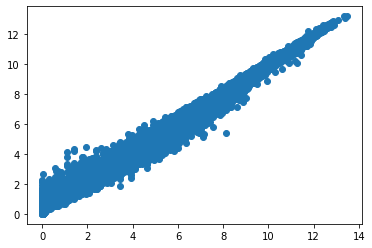

In [149]:
# Tackice oslikavaju blagu liniju sto ukazuje na vecu tacnost dobijenih predikcija kod ovog modela

plt.scatter(y_train, train_pred_rf_1)

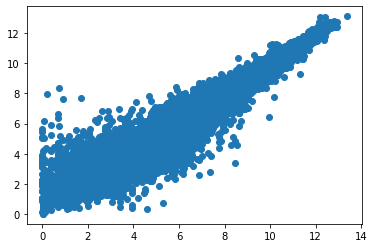

In [150]:
# U slucaju testa vidimo da su tackice na grafiku rasprsenije na sta i ukazuje veca greska na test setu nego na train setu

plt.scatter(y_test, test_pred_rf_1)

In [151]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rf_1, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (117.43219146728515, 4.664307668956927),
 'score_time': (3.2384966373443604, 0.19824712627022853),
 'test_score': (-0.18158954424185086, 0.0017200696224692047),
 'train_score': (-0.06742707794931287, 0.00016054369407468686)}

In [152]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rf_1, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (115.91798815727233, 1.2762702396410024),
 'score_time': (3.2759938716888426, 0.22005069072901215),
 'test_MAE': (-15839.169721359654, 47.1957095949792),
 'train_MAE': (-15905.842271699332, 15.320067657848714),
 'test_RMSE': (-27335.065821696997, 91.26336935268036),
 'train_RMSE': (-27508.677090366436, 46.44564312045995),
 'test_MSE': (-747214152.4790928, 4981291.771413014),
 'train_MSE': (-756729472.4598159, 2556151.14425025),
 'test_R2': (0.9725503186486181, 0.0003512751353142022),
 'train_R2': (0.9961689301167078, 2.1803544237291787e-05)}

## II model optimizacija parametara

## 1. optimizacija
### n_estimators I nacin

In [153]:
# Optimizacija parametara algoritma: n_estimators = broj stabala

random_forest_params = {'n_estimators': [20, 30, 50]}
grid_rf = GridSearchCV(RandomForestRegressor(), random_forest_params, cv=5, scoring='neg_root_mean_squared_error')
grid_rf.fit(X,y)
print('Best param: ', grid_rf.best_params_)

Best param:  {'n_estimators': 50}


In [155]:
model_rf_2 = RandomForestRegressor(n_estimators = 50)

In [156]:
model_rf_2.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50)

In [157]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rf_2, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (59.954506969451906, 3.3486568307029754),
 'score_time': (1.5458832263946534, 0.04605643861505324),
 'test_score': (-0.18276591145454393, 0.001918242564457194),
 'train_score': (-0.06847968630796655, 0.00023767246794136025)}

In [158]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rf_2, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (56.92403216362, 0.40486464694754926),
 'score_time': (1.5106241703033447, 0.022895284687112705),
 'test_MAE': (-15839.556877682666, 48.4745611474064),
 'train_MAE': (-15906.356925712254, 15.710574301668652),
 'test_RMSE': (-27336.250739449613, 99.78784563577737),
 'train_RMSE': (-27512.324635620716, 47.225931340583266),
 'test_MSE': (-747280562.104196, 5445405.527388044),
 'train_MSE': (-756930237.1443738, 2599579.1745817196),
 'test_R2': (0.9722566363977705, 0.0003990517125901517),
 'train_R2': (0.9960137642472533, 1.765430408540143e-05)}

## III model optimizacija parametara

## 2. optimizacija

### n_estimators II nacin

In [183]:
rf_params = [56, 58, 60]
for i in rf_params:
    rf = RandomForestRegressor(n_estimators=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

56 -0.1823332388336651
58 -0.18248917731287773
60 -0.18217372112984365


In [184]:
rf_params = [100, 200, 300]
for i in rf_params:
    rf = RandomForestRegressor(n_estimators=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

100 -0.18174575694580272
200 -0.18110484417440575
300 -0.18104101207693107


In [186]:
rf_params = [350, 400, 500]
for i in rf_params:
    rf = RandomForestRegressor(n_estimators=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

350 -0.1808954773144434
400 -0.18087352549988567
500 -0.18085002941980358


In [172]:
rf_params = [600, 700, 800, 900, 1000]
for i in rf_params:
    rf = RandomForestRegressor(n_estimators=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

600 nan
700 nan
800 nan
900 nan
1000 nan


## III model
### n_estimators = 60

In [173]:
model_rf_3 = RandomForestRegressor(n_estimators = 60)

In [174]:
model_rf_3.fit(X_train, y_train)

RandomForestRegressor(n_estimators=60)

In [182]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rf_3, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (68.43011798858643, 0.416493945210922),
 'score_time': (1.818007469177246, 0.049055735123535824),
 'test_score': (-0.18249211828348166, 0.002030728210160007),
 'train_score': (-0.06809972128058976, 0.00022510758396827155)}

In [187]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rf_3, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (70.77284579277038, 5.423547497139963),
 'score_time': (1.8305082321166992, 0.0688397037031379),
 'test_MAE': (-15839.761922203277, 47.1448694451051),
 'train_MAE': (-15905.984283420232, 14.96314628459368),
 'test_RMSE': (-27334.353007842437, 99.35254047873335),
 'train_RMSE': (-27508.2093512061, 46.36765370574285),
 'test_MSE': (-747176725.2846444, 5423361.152970884),
 'train_MSE': (-756703731.6690929, 2551347.637350304),
 'test_R2': (0.9723569596795072, 0.0004352637360265897),
 'train_R2': (0.9960557703736681, 2.6136664212132193e-05)}

## IV model
### n_estimators = 300

In [149]:
model_rf_4 = RandomForestRegressor(n_estimators = 300)

In [150]:
model_rf_4.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [151]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rf_4, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (375.1480763912201, 22.935195933952244),
 'score_time': (38.16794090270996, 21.66377070266286),
 'test_score': (-0.18103870764278654, 0.0018174622265704082),
 'train_score': (-0.06675830822995021, 0.00016208532268119659)}

In [152]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rf_4, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (363.8037453174591, 5.669224359435748),
 'score_time': (15.501962614059448, 3.787360406461795),
 'test_MAE': (-15837.143569310536, 48.045585915687404),
 'train_MAE': (-15904.554721275166, 15.208160365562675),
 'test_RMSE': (-27327.793097606664, 93.47817058655029),
 'train_RMSE': (-27504.57441109661, 47.19377024595135),
 'test_MSE': (-746817013.7539747, 5099859.864365368),
 'train_MSE': (-756503840.7875004, 2597040.490741256),
 'test_R2': (0.972718410945905, 0.00036336621572779024),
 'train_R2': (0.996275307489265, 2.54530355905302e-05)}

## V model
### n_estimators = 350

In [148]:
model_rf_5 = RandomForestRegressor(n_estimators = 350)

In [149]:
model_rf_5.fit(X_train, y_train)

RandomForestRegressor(n_estimators=350)

In [148]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rf_5, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (438.11833629608157, 23.221473298793846),
 'score_time': (58.49765815734863, 8.380777726264835),
 'test_score': (-0.1809193898367016, 0.001810607494376713),
 'train_score': (-0.06676197530038977, 0.00015799801950046227)}

In [149]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rf_5, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (435.0955552101135, 7.652287321312402),
 'score_time': (59.47439603805542, 10.322179161831027),
 'test_MAE': (-15837.041785226069, 47.47550936061602),
 'train_MAE': (-15904.693156182071, 15.150274797871104),
 'test_RMSE': (-27325.55935340937, 93.66295151916543),
 'train_RMSE': (-27505.24119809294, 45.25629257773032),
 'test_MSE': (-746694966.7251855, 5109753.6939785415),
 'train_MSE': (-756540341.497287, 2490161.761867051),
 'test_R2': (0.9727743839558991, 0.00038056028067990727),
 'train_R2': (0.9962861733079602, 1.7986442816546564e-05)}

## VI model
### n_estimators = 500

In [143]:
model_rf_6 = RandomForestRegressor(n_estimators = 500)

In [144]:
model_rf_6.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

In [145]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rf_6, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (576.752105665207, 17.65723792716635),
 'score_time': (140.10695037841796, 2.6566766996951743),
 'test_score': (-0.18085829345236187, 0.0017933631925771641),
 'train_score': (-0.06664397338523367, 0.00017516809025166689)}

In [146]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rf_6, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (597.0032215595245, 26.2710179007265),
 'score_time': (130.83465662002564, 9.92529398205521),
 'test_MAE': (-15836.770215828621, 48.185766118580936),
 'train_MAE': (-15904.600017440322, 14.719549338408873),
 'test_RMSE': (-27322.14569767095, 94.88282478071767),
 'train_RMSE': (-27504.288170689746, 43.93562720118201),
 'test_MSE': (-746508648.2751973, 5175087.98684166),
 'train_MSE': (-756487798.1156814, 2417384.8599256068),
 'test_R2': (0.9727496490329874, 0.000371069574468085),
 'train_R2': (0.9963017185015512, 2.9077066324844627e-05)}

## VII model optimizacija parametara

## 3. optimizacija

### max_depth

In [189]:
rf_params = [25, 27, 30]
for i in rf_params:
    rf = RandomForestRegressor(max_depth=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

25 -0.18168577573150196
27 -0.1814211439579135
30 -0.18155014474429457


In [149]:
rf_params = [32, 34, 36, 40]
for i in rf_params:
    rf = RandomForestRegressor(max_depth=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

32 -0.1815613592791863
34 -0.18155584564839722
36 -0.18140754813140106
40 -0.1815443768279394


In [171]:
rf_params = [3, 5, 7]
for i in rf_params:
    rf = RandomForestRegressor(max_depth=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

3 -1.2576704582274343
5 -1.0787225654116088
7 -0.8416714148020461


In [145]:
rf_params = [8, 9 ,10, 11, 12]
for i in rf_params:
    rf = RandomForestRegressor(max_depth=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

8 -0.7298108188536034
9 -0.5966719581343655
10 -0.4788611674398441
11 -0.3962548522725387
12 -0.3434500277064304


### max_features

In [191]:
rf_params = [2, 3, 4, 5, 6, 7]
for i in rf_params:
    rf = RandomForestRegressor(max_features=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

2 -1.0920994188646467
3 -0.9709185886705342
4 -0.805803721330328
5 -0.6388330835143228
6 -0.45777461983196677
7 -0.33184439392871684


In [223]:
rf_params = [7, 8, 9, 10]
for i in rf_params:
    rf = RandomForestRegressor(max_features=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

7 -0.3317569001996857
8 -0.25172552369126694
9 -0.20906616678564274
10 -0.1901744296845794


In [252]:
rf_params = [11, 12, 13, 14, 15]
for i in rf_params:
    rf = RandomForestRegressor(max_features=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

11 -0.18274943983817218
12 -0.18051136955708463
13 -0.17981025624652533
14 -0.18027626096058458
15 -0.18157804539817313


### min_samples_split

In [193]:
rf_params = [2, 3, 4]
for i in rf_params:
    rf = RandomForestRegressor(min_samples_split=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

2 -0.18175351138709842
3 -0.18172705172555387
4 -0.18219505619844423


In [253]:
rf_params = [5, 6, 7]
for i in rf_params:
    rf = RandomForestRegressor(min_samples_split=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

5 -0.18279677396794683
6 -0.18364959158307606
7 -0.18460759036354238


### min_samples_leaf

In [195]:
rf_params = [1, 2, 3]
for i in rf_params:
    rf = RandomForestRegressor(min_samples_leaf=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

1 -0.18162649504248649
2 -0.1834297753345115
3 -0.18678818922203783


In [254]:
rf_params = [4, 5, 6]
for i in rf_params:
    rf = RandomForestRegressor(min_samples_leaf=i)
    wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

4 -0.19048198937129
5 -0.19452570479764933
6 -0.19845973662395147


### VII optimizovane vrednosti svih parametara bez n_estimators

In [274]:
model_rf_7 = RandomForestRegressor(max_depth = 36, max_features = 13, min_samples_split = 3, min_samples_leaf = 1)

In [275]:
model_rf_7.fit(X_train, y_train)

RandomForestRegressor(max_depth=36, max_features=13, min_samples_split=3)

In [276]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rf_7, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (97.756680727005, 2.036592235400002),
 'score_time': (2.907636117935181, 0.08220242444082967),
 'test_score': (-0.18003503360014092, 0.002015894800906736),
 'train_score': (-0.07643224742350571, 0.00020985639120708286)}

In [277]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rf_7, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (100.55655093193054, 3.3633943947905847),
 'score_time': (2.8290786743164062, 0.07606972915173446),
 'test_MAE': (-15811.948405394229, 49.88243050881642),
 'train_MAE': (-15886.351100981585, 14.919737552141195),
 'test_RMSE': (-27245.58576375697, 111.17676743848207),
 'train_RMSE': (-27451.58464370765, 45.78196688849608),
 'test_MSE': (-742334303.8838546, 6049011.324094537),
 'train_MSE': (-753591595.4391379, 2514975.3372243466),
 'test_R2': (0.9729797490407808, 0.0005126022599552339),
 'train_R2': (0.9949606063755659, 3.295218738740669e-05)}

### VIII optimizovane vrednosti svih parametara 

In [142]:
model_rf_8 = RandomForestRegressor(n_estimators = 350, max_depth = 36, max_features = 13, min_samples_split = 3, min_samples_leaf = 1)

In [143]:
model_rf_8.fit(X_train, y_train)

RandomForestRegressor(max_depth=36, max_features=13, min_samples_split=3,
                      n_estimators=350)

In [144]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rf_8, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (333.23879199028016, 13.18305374634086),
 'score_time': (9.81927137374878, 0.23508695901358567),
 'test_score': (-0.17918296359382777, 0.002047255253195041),
 'train_score': (-0.07568072967890516, 0.00025433814354715735)}

In [145]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rf_8, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (327.01305837631224, 1.315099061806635),
 'score_time': (9.666534662246704, 0.18612369423913114),
 'test_MAE': (-15810.614203782941, 49.369846043322966),
 'train_MAE': (-15885.716661174602, 15.134342462338505),
 'test_RMSE': (-27237.496332908682, 107.59422408563202),
 'train_RMSE': (-27450.359753600223, 41.92482140646503),
 'test_MSE': (-741892783.0022707, 5852025.777262274),
 'train_MSE': (-753524008.2927248, 2302557.9853340248),
 'test_R2': (0.9732085899321753, 0.0005146614952167741),
 'train_R2': (0.9950744401023057, 4.131437850031924e-05)}

## IX model selekcija atributa + optimizovani parametri

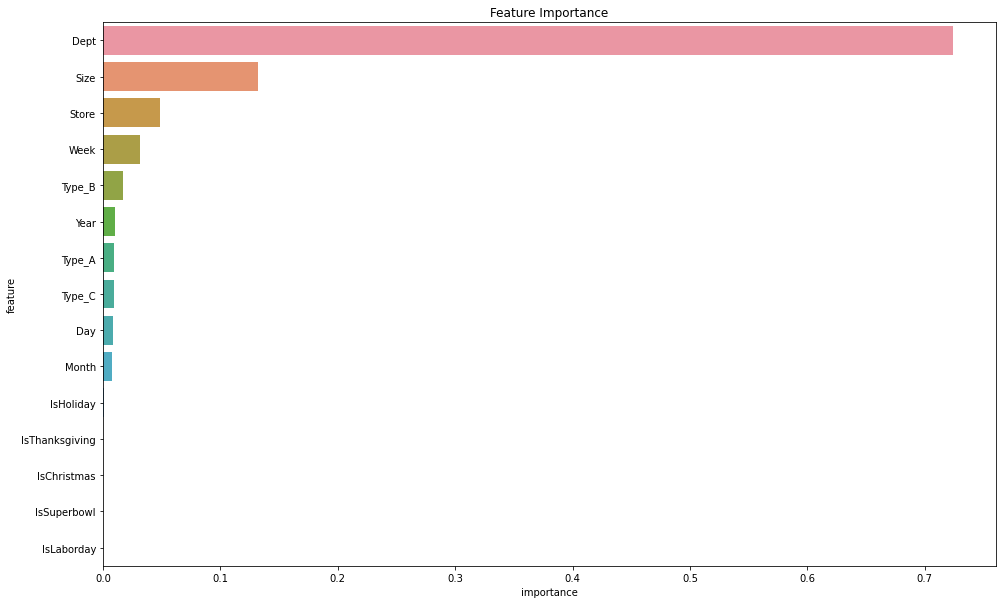

In [154]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_rf_8.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(16,10))
plt.title('Feature Importance')
sns.barplot(data=importance_df, x='importance', y='feature');

In [155]:
X_train_rf = X_train[['Dept', 'Size', 'Store', 'Week', 'Type_B', 'IsHoliday']]

In [158]:
model_rf_9 = RandomForestRegressor(n_estimators = 350, max_depth = 36, max_features = 6, min_samples_split = 3, min_samples_leaf = 1)

In [159]:
model_rf_9.fit(X_train_rf, y_train)

RandomForestRegressor(max_depth=36, max_features=6, min_samples_split=3,
                      n_estimators=350)

In [160]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rf_9, X_train_rf, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (226.64559531211853, 19.606953999186526),
 'score_time': (11.166617441177369, 0.607275228184147),
 'test_score': (-0.23893249721943105, 0.002052800801529318),
 'train_score': (-0.13412921267874744, 0.000505311987767552)}

In [161]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rf_9, X_train_rf, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (219.8517629146576, 3.0167057752744677),
 'score_time': (10.706389379501342, 0.4599060497659466),
 'test_MAE': (-15847.1720447168, 48.29305241428717),
 'train_MAE': (-15871.83897465206, 15.1286054219686),
 'test_RMSE': (-27339.88032114657, 85.23525520507341),
 'train_RMSE': (-27422.81808662926, 46.69705107407649),
 'test_MSE': (-747476321.0233476, 4652036.995703294),
 'train_MSE': (-752013132.42694, 2562123.619437664),
 'test_R2': (0.9486869226066533, 0.0004542256238081188),
 'train_R2': (0.9824589139622206, 5.9994542511997404e-05)}

## X model 8.optimizacija

In [1252]:
max_depth_params = [5, 7, 9]
n_estimators_params = [50, 100]
max_features_params = [3, 4]
for i in max_depth_params:
    for j in n_estimators_params:
        for k in max_features_params:
            rf = RandomForestRegressor(max_depth=i, n_estimators=j, max_features=k)
            wmae = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring=wm))
            print(i, j, k, wmae)

5 50 3 -1.267754732356757
5 50 4 -1.226181788622015
5 100 3 -1.2698368793988801
5 100 4 -1.223153275372328
7 50 3 -1.1972751887268482
7 50 4 -1.1367356996517275
7 100 3 -1.1933077550206614
7 100 4 -1.1426216963929838
9 50 3 -1.1438565727923462
9 50 4 -1.0679631351623762
9 100 3 -1.1301961273475087
9 100 4 -1.064790208015486


In [147]:
# Optimizacija parametara algoritma

random_forest_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 20]}
grid_rf = GridSearchCV(RandomForestRegressor(), random_forest_params, cv=5, scoring='neg_root_mean_squared_error')
grid_rf.fit(X,y)
print('Best param: ', grid_rf.best_params_)

Best param:  {'max_depth': 20, 'n_estimators': 50}


In [1174]:
model_rf_10 = RandomForestRegressor(n_estimators = 50, max_depth = 20)

In [1175]:
model_rf_10.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=50)

In [151]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rf_10, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (50.7586874961853, 0.3262423012278181),
 'score_time': (1.157919979095459, 0.03298959840926181),
 'test_score': (-0.18906734978965054, 0.001627644723643938),
 'train_score': (-0.10283870570110505, 0.0005028925480019059)}

In [1177]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rf_10, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (56.29176592826843, 4.383095756612178),
 'score_time': (1.2973297119140625, 0.1475808919688217),
 'test_MAE': (-15807.41238954482, 48.372118365666424),
 'train_MAE': (-15855.402568272391, 14.45310061854537),
 'test_RMSE': (-27277.486121866845, 99.66267257751136),
 'train_RMSE': (-27414.101101532066, 38.99276245665607),
 'test_MSE': (-744071181.7769439, 5427675.975699206),
 'train_MSE': (-751534459.6405458, 2138631.8738983707),
 'test_R2': (0.9714727282346642, 0.0004557361158342763),
 'train_R2': (0.9919325454587712, 4.313240465526421e-05)}

## XI model 9. optimizacija

In [ ]:
model_rf_11 = RandomForestRegressor(n_estimators = 50, max_depth = 18)

In [ ]:
model_rf_11.fit(X_train, y_train)

In [162]:
# Evaluacija WMAE

cv_dict = cross_validate(model_rf_11, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (45.89008059501648, 0.44281744305987497),
 'score_time': (0.9154225349426269, 0.05812452968981702),
 'test_score': (-0.1997817437426786, 0.00205593955900076),
 'train_score': (-0.13316877673010458, 0.0004051999575385697)}

In [1178]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_rf_11, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (46.49077877998352, 1.842399085615481),
 'score_time': (1.0001083374023438, 0.05617928984529093),
 'test_MAE': (-15753.256491572723, 52.96374003039963),
 'train_MAE': (-15791.748746264977, 12.436217072776744),
 'test_RMSE': (-27156.224921979097, 111.50927413903746),
 'train_RMSE': (-27276.915875582483, 32.81670182472201),
 'test_MSE': (-737472986.3313377, 6045240.086031761),
 'train_MSE': (-744031216.6195226, 1790753.5443515189),
 'test_R2': (0.9694766564993109, 0.0005080044176534527),
 'train_R2': (0.9867745200672029, 0.00016512902869762107)}

## XGBoost Regressor

## I model

In [157]:
# Instanciranje modela koriscenjem funckije XGBRegressor

model_xgb_1 = xgb.XGBRegressor()

In [158]:
# Ucenje modela

model_xgb_1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [159]:
# Evaluacija WMAE

cv_dict = cross_validate(model_xgb_1, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (11.847745180130005, 0.5091839294375049),
 'score_time': (0.09897575378417969, 0.029997697990314532),
 'test_score': (-0.3034010057405021, 0.0013075047539287989),
 'train_score': (-0.2959822207178238, 0.001395706689541802)}

In [160]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_xgb_1, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (11.724095678329467, 0.5063429612116538),
 'score_time': (0.09079766273498535, 0.028619813740670838),
 'test_MAE': (-15231.118053612076, 45.79115727096122),
 'train_MAE': (-15243.623751477531, 28.440415828756638),
 'test_RMSE': (-26263.71838268881, 68.6099697422227),
 'train_RMSE': (-26294.196130621316, 125.92255838096865),
 'test_MSE': (-689787610.6131341, 3603760.9218570217),
 'train_MSE': (-691400606.6462904, 6620953.526762557),
 'test_R2': (0.9397239026671386, 0.0012688315684035354),
 'train_R2': (0.943130293882076, 0.0008705244006016999)}

## II model optimizacija parametara

## 1. optimizacija

In [161]:
# Optimizacija parametara

'''
min_split_loss = parametar koji sprecava overfitting
max_depth = maksimalna dubina
learning_rate = znacajnost smanjenja greske svake iteracije
'''

xgb_params = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30], 
              'min_split_loss': [0.0, 0.1, 0.2 , 0.3, 0.4], 
              'max_depth': [4, 6, 8, 10, 12]}
grid_xgb = GridSearchCV(xgb.XGBRegressor(), xgb_params, cv=5, scoring='neg_root_mean_squared_error')
grid_xgb.fit(X,y)
print('Best param: ', grid_xgb.best_params_)

Best param:  {'learning_rate': 0.1, 'max_depth': 10, 'min_split_loss': 0.2}


In [162]:
model_xgb_2 = xgb.XGBRegressor(learning_rate = 0.1, min_split_loss = 0.1, max_depth = 10)

In [163]:
model_xgb_2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.100000001,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, min_split_loss=0.1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [164]:
# Evaluacija WMAE

cv_dict = cross_validate(model_xgb_2, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (22.089571380615233, 0.21576837971915472),
 'score_time': (0.14080848693847656, 0.0052047714687132535),
 'test_score': (-0.23949750837810954, 0.0016879082644139128),
 'train_score': (-0.21758364536407063, 0.0013101828808012796)}

In [165]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_xgb_2, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (22.151726150512694, 0.7125629047159899),
 'score_time': (0.1380392551422119, 0.0013558264244999754),
 'test_MAE': (-15123.860824313926, 42.887520499018606),
 'train_MAE': (-15158.349253282224, 21.305242244339407),
 'test_RMSE': (-25756.293855232496, 94.3012528413179),
 'train_RMSE': (-25853.20393856066, 70.58240982162796),
 'test_MSE': (-663395565.8833746, 4852731.958094559),
 'train_MSE': (-668393135.7653846, 3650874.6265919423),
 'test_R2': (0.9585127000629037, 0.0007170528825762791),
 'train_R2': (0.9672405623116905, 0.0005215465148651087)}

## III model optimizacija parametara

## 2. optimizacija 

### learning rate

In [208]:
xgb_params = [0.10, 0.15, 0.20]
for i in xgb_params:
    xgb_model = xgb.XGBRegressor(learning_rate=i)
    wmae = np.mean(cross_val_score(xgb_model, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

0.1 -0.4346864938660497
0.15 -0.3731661260053968
0.2 -0.3384456398347402


### min_split_loss

In [210]:
xgb_params = [0.1, 0.2 , 0.3, 0.4]
for i in xgb_params:
    xgb_model = xgb.XGBRegressor(min_split_loss=i)
    wmae = np.mean(cross_val_score(xgb_model, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

0.1 -0.30245722608619985
0.2 -0.3037173614301497
0.3 -0.304137934887058
0.4 -0.3030087270212819


### max_depth

In [212]:
xgb_params = [4, 6, 8, 10, 12]
for i in xgb_params:
    xgb_model = xgb.XGBRegressor(max_depth=i)
    wmae = np.mean(cross_val_score(xgb_model, X_train, y_train, cv=5, scoring=wm))
    print(i, wmae)

4 -0.4350815642544218
6 -0.3034010057405021
8 -0.23010673000536594
10 -0.19447832603977813
12 -0.18338899783959167


In [865]:
model_xgb_3 = xgb.XGBRegressor(learning_rate = 0.2, min_split_loss = 0.1, max_depth = 12)

In [866]:
model_xgb_3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.100000001,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=12,
             min_child_weight=1, min_split_loss=0.1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [168]:
# Evaluacija WMAE

cv_dict = cross_validate(model_xgb_3, X_train, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (29.64604139328003, 0.4337364947855648),
 'score_time': (0.20696940422058105, 0.01050206089042807),
 'test_score': (-0.1852045418205265, 0.0019917527977061627),
 'train_score': (-0.12385952766955406, 0.00038179089758380434)}

In [169]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_xgb_3, X_train, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (29.434515285491944, 0.4575040181179645),
 'score_time': (0.2054443836212158, 0.008629483165702988),
 'test_MAE': (-15722.594791546817, 55.881223764351006),
 'train_MAE': (-15789.319085074734, 14.855656174653914),
 'test_RMSE': (-27093.318000417632, 137.43526004010272),
 'train_RMSE': (-27245.046887940814, 39.885998506852445),
 'test_MSE': (-734066768.7224563, 7443196.890500593),
 'train_MSE': (-742294170.8189703, 2173745.002468755),
 'test_R2': (0.972128853579459, 0.000363411128138191),
 'train_R2': (0.989986630517684, 0.00011602903316018725)}

## IV model selekcija atributa + optimizovani parametri

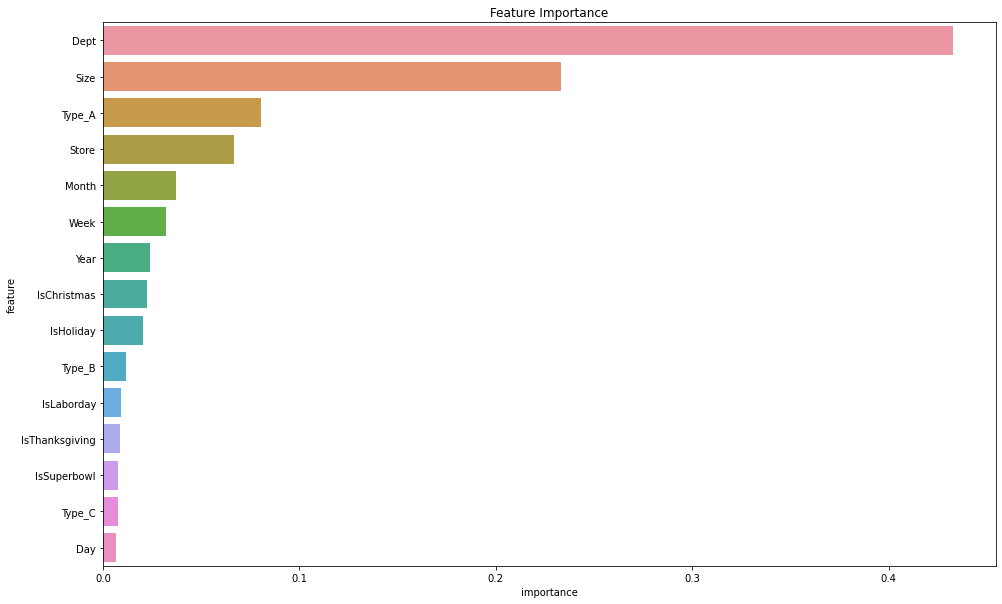

In [207]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_xgb_3.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(16,10))
plt.title('Feature Importance')
sns.barplot(data=importance_df, x='importance', y='feature');

In [208]:
X_train_xgb = X_train[['Dept', 'Size', 'Type_A', 'Store', 'IsHoliday']]

In [209]:
model_xgb_4 = xgb.XGBRegressor(learning_rate = 0.2, min_split_loss = 0.1, max_depth = 12)

In [210]:
model_xgb_4.fit(X_train_xgb, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.100000001,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=12,
             min_child_weight=1, min_split_loss=0.1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [211]:
# Evaluacija WMAE

cv_dict = cross_validate(model_xgb_4, X_train_xgb, y_train, cv = 5, scoring = wm, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (15.843855285644532, 0.2930053754331397),
 'score_time': (0.14540090560913085, 0.0017044788079512302),
 'test_score': (-0.31253398134006993, 0.0014128989257036328),
 'train_score': (-0.295351887895801, 0.0005299592391827939)}

In [212]:
# Evaluacija MAE, RMSE, MSE, R2

cv_dict = cross_validate(model_xgb_4, X_train_xgb, y_train, cv = 5, scoring={'MAE':unlog_mae, 'RMSE':unlog_rmse, 'MSE':unlog_mse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (15.679631233215332, 0.35910267522581624),
 'score_time': (0.1448990821838379, 0.002602220393225326),
 'test_MAE': (-15380.817029991736, 47.26035866355268),
 'train_MAE': (-15380.59402798966, 13.285817059295535),
 'test_RMSE': (-26281.139997922037, 95.91365039547215),
 'train_RMSE': (-26283.541541378458, 32.56368711359827),
 'test_MSE': (-690707519.0187095, 5048007.491349468),
 'train_MSE': (-690825616.3510855, 1711966.5003493833),
 'test_R2': (0.917836993950614, 0.0013044430751291954),
 'train_R2': (0.9232771767204964, 0.0003250453161445847)}

## 5. Poredjenje performansi algoritama

<img src='img/Uporedna analiza I.png' width=600>
<img src='img/Uporedna analiza II 2.png' width=600>
<img src='img/Uporedna analiza III.png' width=600>
<img src='img/Uporedna analiza IV.png' width=600>

## 6. Primena modela na konacan test set

In [873]:
'''
Test set koji je dat u opisu takmicenja na Kagglu cuva se konacnu evaluaciju modela, to jest za dobijanje konacnih predikcija
koje ce biti finalne i spremne za postavljanje na Kaggle.
Uzece se u obzir samo najbolji modeli koji su dobijeni u prethodnoj fazi i kreirace se konacne predkcije.
'''

'\nTest set koji je dat u opisu takmicenja na Kagglu cuva se konacnu evaluaciju modela, to jest za dobijanje konacnih predikcija\nkoje ce biti finalne i spremne za postavljanje na Kaggle.\nUzece se u obzir samo najbolji modeli koji su dobijeni u prethodnoj fazi i kreirace se konacne predkcije.\n'

## Linear regression

In [1165]:
df_test_lr = final_data_test_scaled[['Year', 'Type_A', 'Type_B', 'IsHoliday']]

In [1166]:
pred_lr_test = model_lr_2.predict(df_test_lr)

In [1167]:
pred_lr_test_exp = np.exp(pred_lr_test)-1

In [1168]:
test_data['Weekly_Sales'] = pred_lr_test_exp

In [1169]:
results_lr = test_data[['Store','Date','Weekly_Sales']]

In [1170]:
results_lr.head()

,Store,Date,Weekly_Sales
0,1,2012-11-02,7809.69379
1,1,2012-11-09,7809.69379
2,1,2012-11-16,7809.69379
3,1,2012-11-23,7809.69379
4,1,2012-11-30,7809.69379


In [1171]:
results_lr.to_csv('results_lr.csv')

In [1172]:
test_data.drop(['Weekly_Sales'], axis = 1, inplace = True)

## Ridge regression

In [986]:
pred_rr_test = model_rr_3.predict(final_data_test_scaled)

In [987]:
pred_rr_test_exp = np.exp(pred_rr_test)-1

In [988]:
test_data['Weekly_Sales'] = pred_rr_test_exp

In [989]:
results_rr = test_data[['Store','Date','Weekly_Sales']]

In [990]:
results_rr.head()

,Store,Date,Weekly_Sales
0,1,2012-11-02,6030.405445
1,1,2012-11-09,6040.595705
2,1,2012-11-16,6050.803183
3,1,2012-11-23,6061.027906
4,1,2012-11-30,6071.269904


In [991]:
results_rr.to_csv('results_rr.csv')

In [992]:
test_data.drop(['Weekly_Sales'], axis=1, inplace=True)

## Decision tree

In [1200]:
df_test_dt = final_data_test_scaled[['Dept', 'Size', 'Store', 'Week']]

In [1201]:
pred_dt_test = model_dt_5.predict(df_test_dt)

In [1202]:
pred_dt_test_exp = np.exp(pred_dt_test)-1

In [1203]:
test_data['Weekly_Sales'] = pred_dt_test_exp

In [1204]:
results_dt = test_data[['Store','Date','Weekly_Sales']]

In [1205]:
results_dt.head()

,Store,Date,Weekly_Sales
0,1,2012-11-02,16255.838231
1,1,2012-11-09,44003.784718
2,1,2012-11-16,10154.723382
3,1,2012-11-23,35416.704556
4,1,2012-11-30,18744.684506


In [1206]:
results_dt.to_csv('results_dt.csv')

In [1207]:
test_data.drop(['Weekly_Sales'], axis = 1, inplace = True)

## KNN

In [1001]:
pred_knn_test = model_knn_4.predict(final_data_test_scaled)

In [1002]:
pred_knn_test_exp = np.exp(pred_knn_test)-1

In [1003]:
test_data['Weekly_Sales'] = pred_knn_test_exp

In [1004]:
results_knn = test_data[['Store','Date','Weekly_Sales']]

In [1005]:
results_knn.head()

,Store,Date,Weekly_Sales
0,1,2012-11-02,24594.016813
1,1,2012-11-09,24594.016813
2,1,2012-11-16,24594.016813
3,1,2012-11-23,24594.016813
4,1,2012-11-30,26700.127623


In [1006]:
results_knn.to_csv('results_knn.csv')

In [1007]:
test_data.drop(['Weekly_Sales'], axis=1, inplace=True)

## Random Forest

In [1008]:
pred_rf_test = model_rf_11.predict(final_data_test_scaled)

In [1009]:
pred_rf_test_exp = np.exp(pred_rf_test)-1

In [1010]:
test_data['Weekly_Sales'] = pred_rf_test_exp

In [1011]:
results_rf = test_data[['Store','Date','Weekly_Sales']]

In [1012]:
results_rf.head()

,Store,Date,Weekly_Sales
0,1,2012-11-02,20773.358256
1,1,2012-11-09,45922.681292
2,1,2012-11-16,9887.094938
3,1,2012-11-23,38589.096965
4,1,2012-11-30,29809.380258


In [1013]:
results_rf.to_csv('results_rf.csv')

In [1014]:
test_data.drop(['Weekly_Sales'], axis = 1, inplace = True)

## XGBoost

In [1015]:
pred_xgb_test = model_xgb_3.predict(final_data_test_scaled)

In [1016]:
pred_xgb_test_exp = np.exp(pred_xgb_test)-1

In [1017]:
test_data['Weekly_Sales'] = pred_xgb_test_exp

In [1018]:
results_xgb = test_data[['Store','Date','Weekly_Sales']]

In [1019]:
results_xgb.head()

,Store,Date,Weekly_Sales
0,1,2012-11-02,22276.947266
1,1,2012-11-09,44476.628906
2,1,2012-11-16,9481.232422
3,1,2012-11-23,37396.097656
4,1,2012-11-30,29732.474609


In [1020]:
results_xgb.to_csv('results_xgb.csv')

In [1021]:
test_data.drop(['Weekly_Sales'], axis = 1, inplace = True)